In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

In [2]:
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)

In [3]:
df = arrivals_dataset.get_data_without_missing_values()

In [4]:
# ========================================
# ANÁLISE DE COMPLETUDE DE DADOS POR PAÍS
# ========================================

# Agregar por data, continente E país
df_rj_countries = process_df(
    df=df, 
    state="rio_de_janeiro", 
    agg_cols=["date", "continent", "country"], 
    value_cols="arrivals", 
    agg_func="sum"
)

print("="*80)
print("ANÁLISE DE COMPLETUDE DE DADOS POR PAÍS - RIO DE JANEIRO")
print("="*80 + "\n")

print(f"Dataset agregado por país:")
print(f"  Total de registros: {len(df_rj_countries):,}")
print(f"  Período: {df_rj_countries['date'].min()} até {df_rj_countries['date'].max()}")
print(f"  Países únicos: {df_rj_countries['country'].nunique()}")
print(f"  Continentes: {df_rj_countries['continent'].nunique()}")

# Obter período completo dos dados
date_range = pd.date_range(
    start=df_rj_countries['date'].min(), 
    end=df_rj_countries['date'].max(), 
    freq='MS'
)
total_months = len(date_range)

print(f"\nPeríodo esperado: {total_months} meses")

# ========================================
# 1. ANÁLISE GERAL POR PAÍS
# ========================================
print("\n" + "="*80)
print("1. COMPLETUDE DE REGISTROS POR PAÍS")
print("="*80 + "\n")

# Contar registros por país
country_analysis = df_rj_countries.groupby(['continent', 'country']).agg({
    'date': 'count',  # Número de registros
    'arrivals': ['sum', lambda x: (x == 0).sum(), lambda x: x.isna().sum()]
}).round(2)

country_analysis.columns = ['N_Records', 'Total_Arrivals', 'Zero_Count', 'Null_Count']

# Adicionar métricas de completude
country_analysis['Expected_Records'] = total_months
country_analysis['Missing_Records'] = total_months - country_analysis['N_Records']
country_analysis['Completeness_%'] = (country_analysis['N_Records'] / total_months * 100).round(2)
country_analysis['Zero_%'] = (country_analysis['Zero_Count'] / country_analysis['N_Records'] * 100).round(2)

# Ordenar por completude
country_analysis = country_analysis.sort_values('Completeness_%', ascending=False)

# Mostrar todos os países
print(country_analysis.to_string())

# ========================================
# 2. ESTATÍSTICAS GERAIS
# ========================================
print("\n" + "="*80)
print("2. ESTATÍSTICAS GERAIS")
print("="*80 + "\n")

print(f"Total de países: {len(country_analysis)}")
print(f"Países com 100% de completude: {(country_analysis['Completeness_%'] == 100).sum()}")
print(f"Países com dados faltantes: {(country_analysis['Missing_Records'] > 0).sum()}")
print(f"Países com valores zero: {(country_analysis['Zero_Count'] > 0).sum()}")
print(f"Países com valores nulos: {(country_analysis['Null_Count'] > 0).sum()}")

print(f"\nCompletude média: {country_analysis['Completeness_%'].mean():.2f}%")
print(f"Completude mínima: {country_analysis['Completeness_%'].min():.2f}%")
print(f"Completude máxima: {country_analysis['Completeness_%'].max():.2f}%")

# ========================================
# 3. PAÍSES COM PROBLEMAS
# ========================================
print("\n" + "="*80)
print("3. PAÍSES COM DADOS PROBLEMÁTICOS")
print("="*80 + "\n")

# Países com menos de 100% de completude
incomplete = country_analysis[country_analysis['Completeness_%'] < 100].copy()

if len(incomplete) > 0:
    print(f"--- PAÍSES COM DADOS FALTANTES ({len(incomplete)} países) ---\n")
    print(incomplete[['N_Records', 'Expected_Records', 'Missing_Records', 'Completeness_%']].to_string())
    
    # Mostrar quantos meses faltam para cada
    print(f"\nResumo de dados faltantes:")
    print(f"  Média de meses faltantes: {incomplete['Missing_Records'].mean():.2f}")
    print(f"  Máximo de meses faltantes: {incomplete['Missing_Records'].max()}")
    print(f"  Países com >12 meses faltantes: {(incomplete['Missing_Records'] > 12).sum()}")
    print(f"  Países com >24 meses faltantes: {(incomplete['Missing_Records'] > 24).sum()}")
else:
    print("✓ Todos os países têm 100% de completude temporal")

# Países com muitos zeros
high_zeros = country_analysis[country_analysis['Zero_%'] > 10].copy()

if len(high_zeros) > 0:
    print(f"\n--- PAÍSES COM >10% DE VALORES ZERO ({len(high_zeros)} países) ---\n")
    print(high_zeros[['N_Records', 'Zero_Count', 'Zero_%', 'Total_Arrivals']].to_string())
    
    print(f"\nResumo de zeros:")
    print(f"  Média de % de zeros: {high_zeros['Zero_%'].mean():.2f}%")
    print(f"  Máximo de % de zeros: {high_zeros['Zero_%'].max():.2f}%")
    print(f"  Países com >50% zeros: {(high_zeros['Zero_%'] > 50).sum()}")
else:
    print("\n✓ Nenhum país tem mais de 10% de valores zero")

# ========================================
# 4. ANÁLISE POR CONTINENTE
# ========================================
print("\n" + "="*80)
print("4. COMPLETUDE POR CONTINENTE")
print("="*80 + "\n")

for continent in sorted(df_rj_countries['continent'].unique()):
    print(f"\n{'='*80}")
    print(f"CONTINENTE: {continent.upper().replace('_', ' ')}")
    print(f"{'='*80}\n")
    
    # Filtrar países do continente
    continent_countries = country_analysis.loc[
        country_analysis.index.get_level_values('continent') == continent
    ].copy()
    
    print(f"Total de países: {len(continent_countries)}")
    print(f"Completude média: {continent_countries['Completeness_%'].mean():.2f}%")
    print(f"Países com 100% completude: {(continent_countries['Completeness_%'] == 100).sum()}")
    print(f"Países com dados faltantes: {(continent_countries['Missing_Records'] > 0).sum()}")
    print(f"Países com >10% zeros: {(continent_countries['Zero_%'] > 10).sum()}")
    
    # Mostrar países com problemas neste continente
    problems = continent_countries[
        (continent_countries['Completeness_%'] < 100) | 
        (continent_countries['Zero_%'] > 10)
    ]
    
    if len(problems) > 0:
        print(f"\n⚠️  Países com problemas ({len(problems)}):\n")
        print(problems[['N_Records', 'Missing_Records', 'Completeness_%', 'Zero_Count', 'Zero_%']].to_string())
    else:
        print("\n✓ Todos os países neste continente estão OK")

# ========================================
# 5. PAÍSES ESPECÍFICOS COM GAPS (DETALHAMENTO)
# ========================================
print("\n" + "="*80)
print("5. DETALHAMENTO DE PAÍSES COM DADOS FALTANTES")
print("="*80 + "\n")

# Para cada país com dados faltantes, mostrar quais datas faltam
incomplete_countries = country_analysis[country_analysis['Missing_Records'] > 0].copy()
incomplete_countries = incomplete_countries.sort_values('Missing_Records', ascending=False)

if len(incomplete_countries) > 0:
    print(f"Total de países com dados faltantes: {len(incomplete_countries)}")
    print(f"\nMostrando os 10 países com mais dados faltantes:\n")
    
    for idx, ((continent, country), row) in enumerate(incomplete_countries.head(10).iterrows(), 1):
        print(f"\n{'-'*80}")
        print(f"{idx}. {country.upper()} ({continent.replace('_', ' ').title()})")
        print(f"{'-'*80}")
        
        # Datas existentes para este país
        country_dates = df_rj_countries[
            (df_rj_countries['country'] == country) &
            (df_rj_countries['continent'] == continent)
        ]['date'].values
        
        country_dates_set = set(pd.to_datetime(country_dates))
        
        # Datas faltantes
        all_dates_set = set(date_range)
        missing_dates = sorted(all_dates_set - country_dates_set)
        
        print(f"Registros existentes: {row['N_Records']} / {total_months}")
        print(f"Registros faltantes: {len(missing_dates)}")
        print(f"Valores zero: {row['Zero_Count']} ({row['Zero_%']:.1f}%)")
        
        if len(missing_dates) > 0:
            # Mostrar primeiras e últimas datas faltantes
            if len(missing_dates) <= 10:
                print(f"Datas faltantes: {[d.strftime('%Y-%m') for d in missing_dates]}")
            else:
                print(f"Primeiras 5 datas faltantes: {[d.strftime('%Y-%m') for d in missing_dates[:5]]}")
                print(f"Últimas 5 datas faltantes: {[d.strftime('%Y-%m') for d in missing_dates[-5:]]}")
            
            # Verificar se é um gap contínuo ou esparso
            if len(missing_dates) > 1:
                date_diffs = [(missing_dates[i+1] - missing_dates[i]).days for i in range(len(missing_dates)-1)]
                avg_gap = np.mean(date_diffs)
                
                if avg_gap < 35:  # ~1 mês
                    gap_type = "CONTÍNUO (período sem dados)"
                else:
                    gap_type = "ESPARSO (dados faltantes pontuais)"
                
                print(f"Tipo de gap: {gap_type}")
                print(f"Gap médio entre datas faltantes: {avg_gap:.1f} dias")
else:
    print("✓ Todos os países têm 100% de completude")

# ========================================
# 6. DISTRIBUIÇÃO TEMPORAL DE PROBLEMAS
# ========================================
print("\n" + "="*80)
print("6. DISTRIBUIÇÃO TEMPORAL DE PROBLEMAS")
print("="*80 + "\n")

# Contar quantos países têm zeros em cada mês
temporal_zeros = df_rj_countries[df_rj_countries['arrivals'] == 0].groupby('date').size()

if len(temporal_zeros) > 0:
    print(f"Meses com pelo menos um país com zero chegadas: {len(temporal_zeros)}")
    print(f"\nTop 10 meses com mais países com zero:\n")
    
    for date, count in temporal_zeros.sort_values(ascending=False).head(10).items():
        total_countries_that_month = len(df_rj_countries[df_rj_countries['date'] == date])
        pct = (count / total_countries_that_month * 100)
        print(f"{date.strftime('%Y-%m')}: {count:>3} países com zero ({pct:>5.1f}% do total)")
else:
    print("✓ Nenhum mês tem países com zero chegadas")

print("\n" + "="*80)
print("✓ Análise de completude por país concluída")
print("="*80)

ANÁLISE DE COMPLETUDE DE DADOS POR PAÍS - RIO DE JANEIRO

Dataset agregado por país:
  Total de registros: 20,415
  Período: 2000-01-01 00:00:00 até 2024-12-01 00:00:00
  Países únicos: 95
  Continentes: 7

Período esperado: 300 meses

1. COMPLETUDE DE REGISTROS POR PAÍS

                                                                    N_Records  Total_Arrivals  Zero_Count  Null_Count  Expected_Records  Missing_Records  Completeness_%  Zero_%
continent                country                                                                                                                                                
africa                   africa_do_sul                                    300         66765.0          10           0               300                0          100.00    3.33
                         angola                                           300        219500.0          13           0               300                0          100.00    4.33
                   

VISUALIZAÇÃO DE LAPSOS TEMPORAIS POR PAÍS

Total de países com dados faltantes: 61



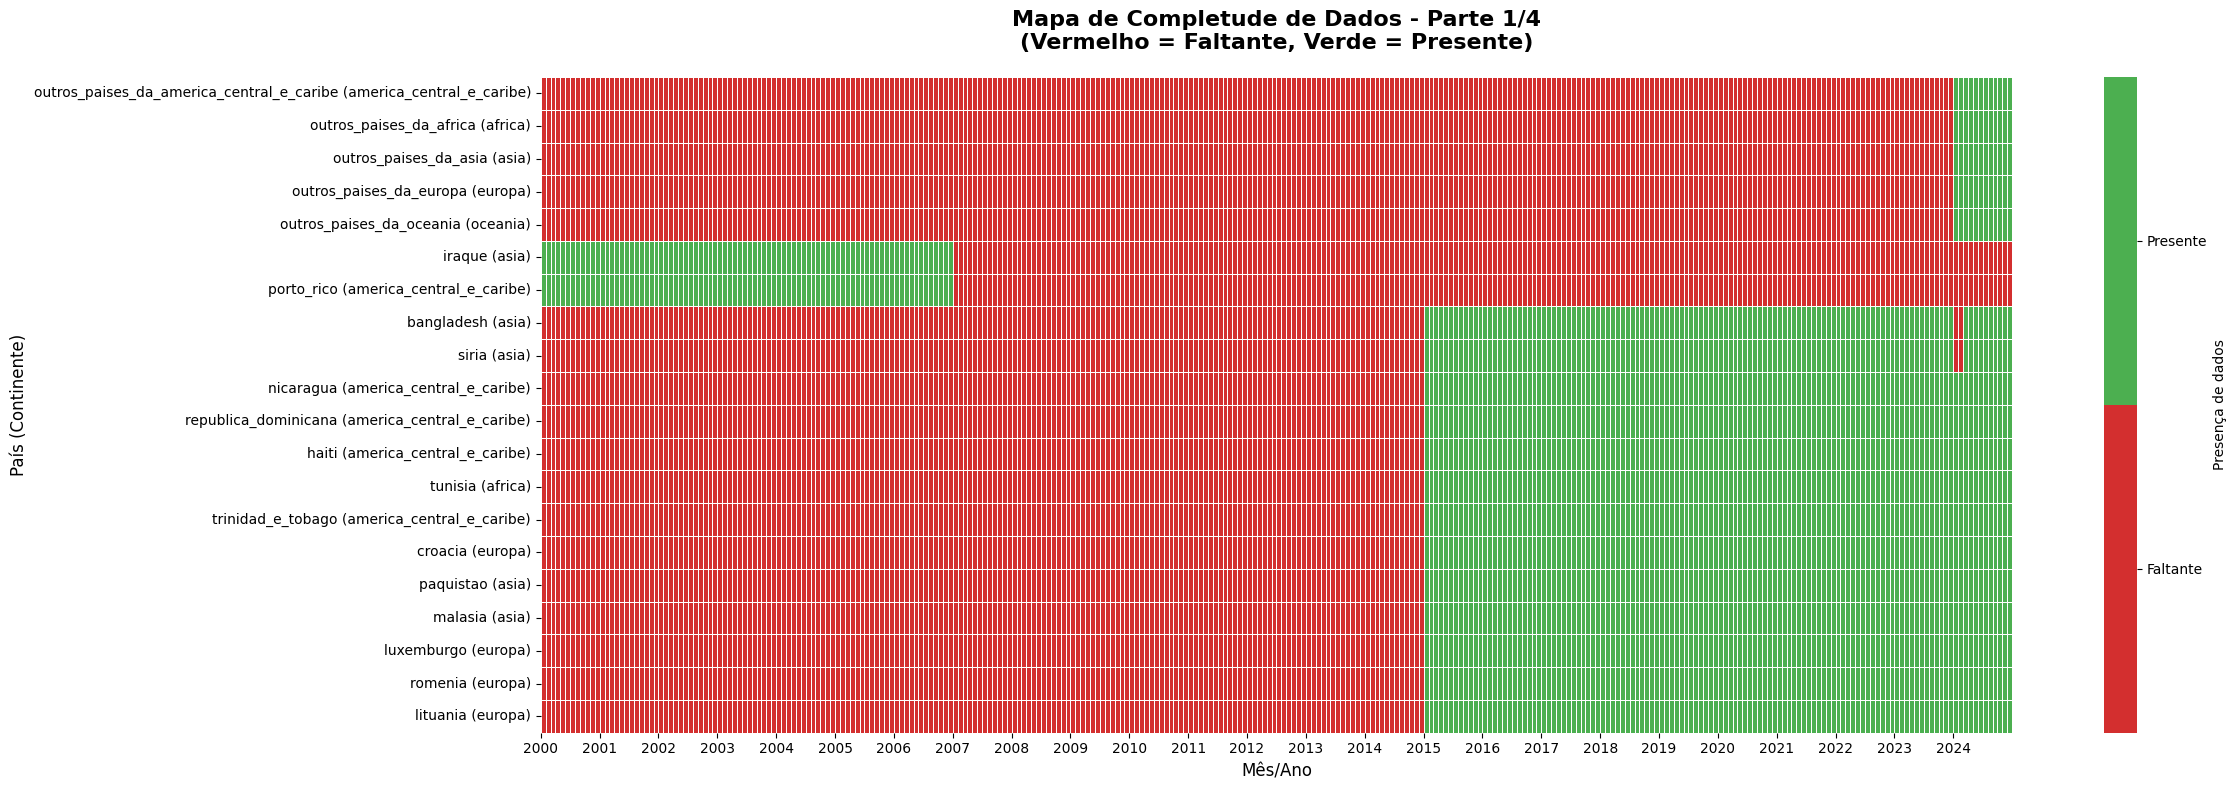

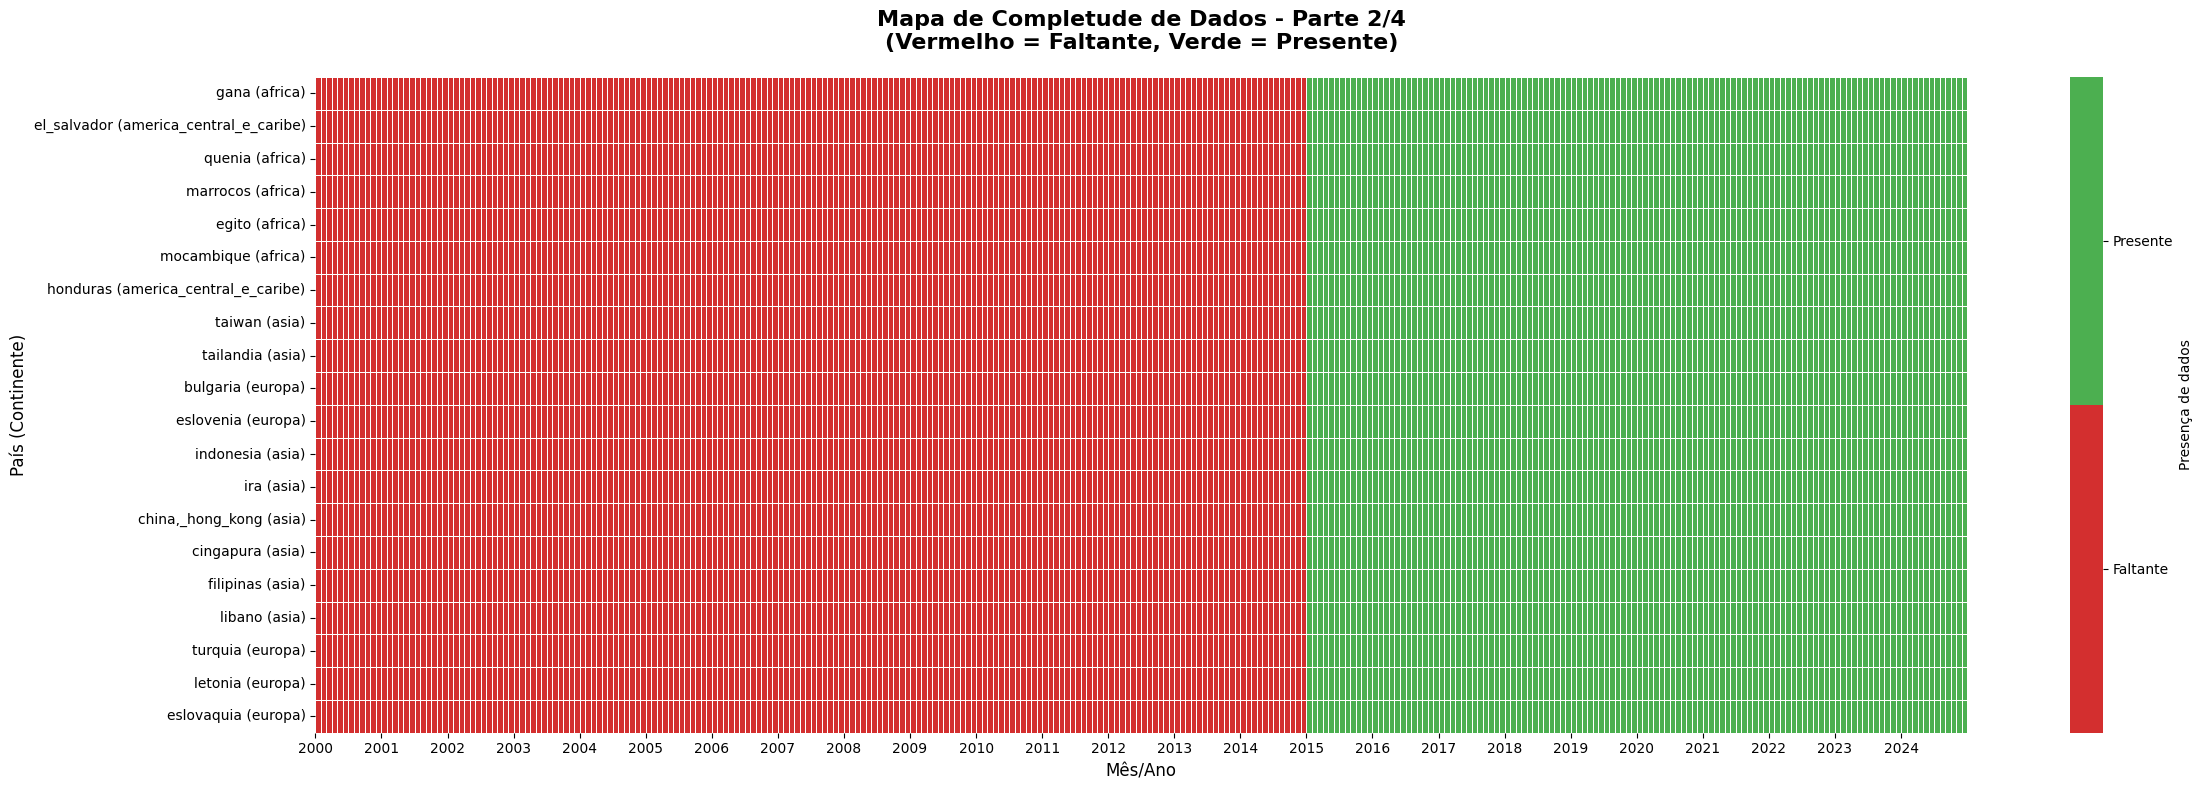

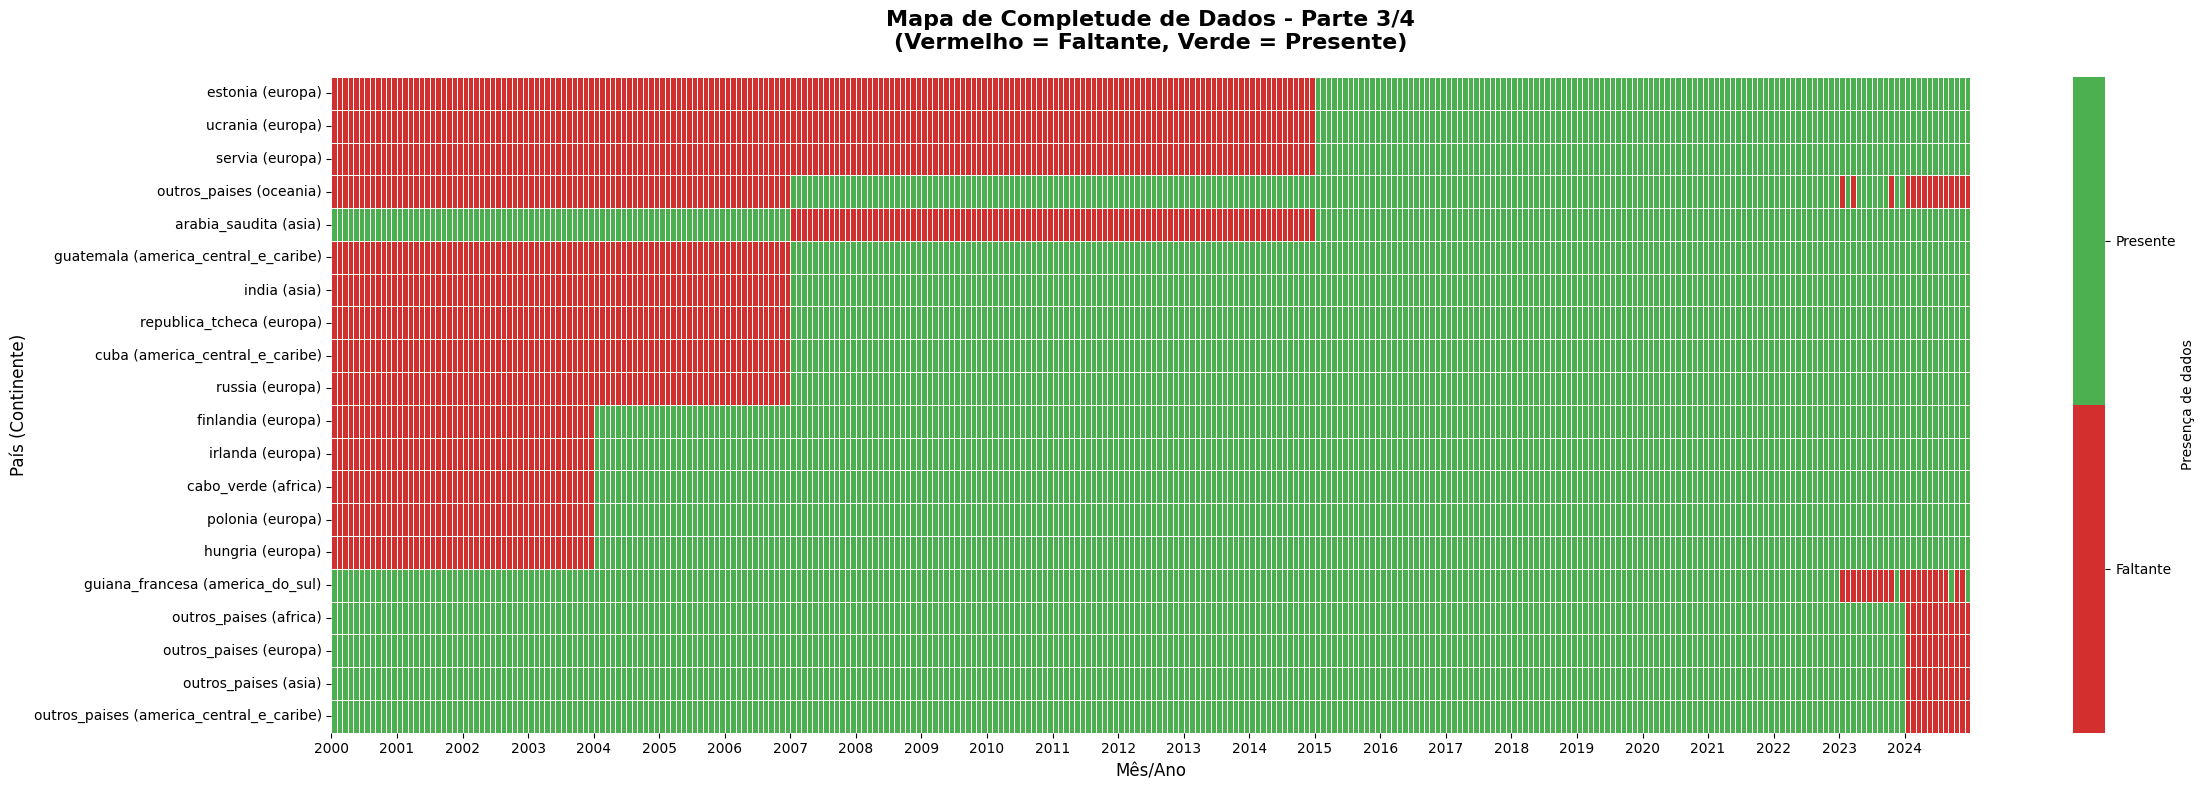

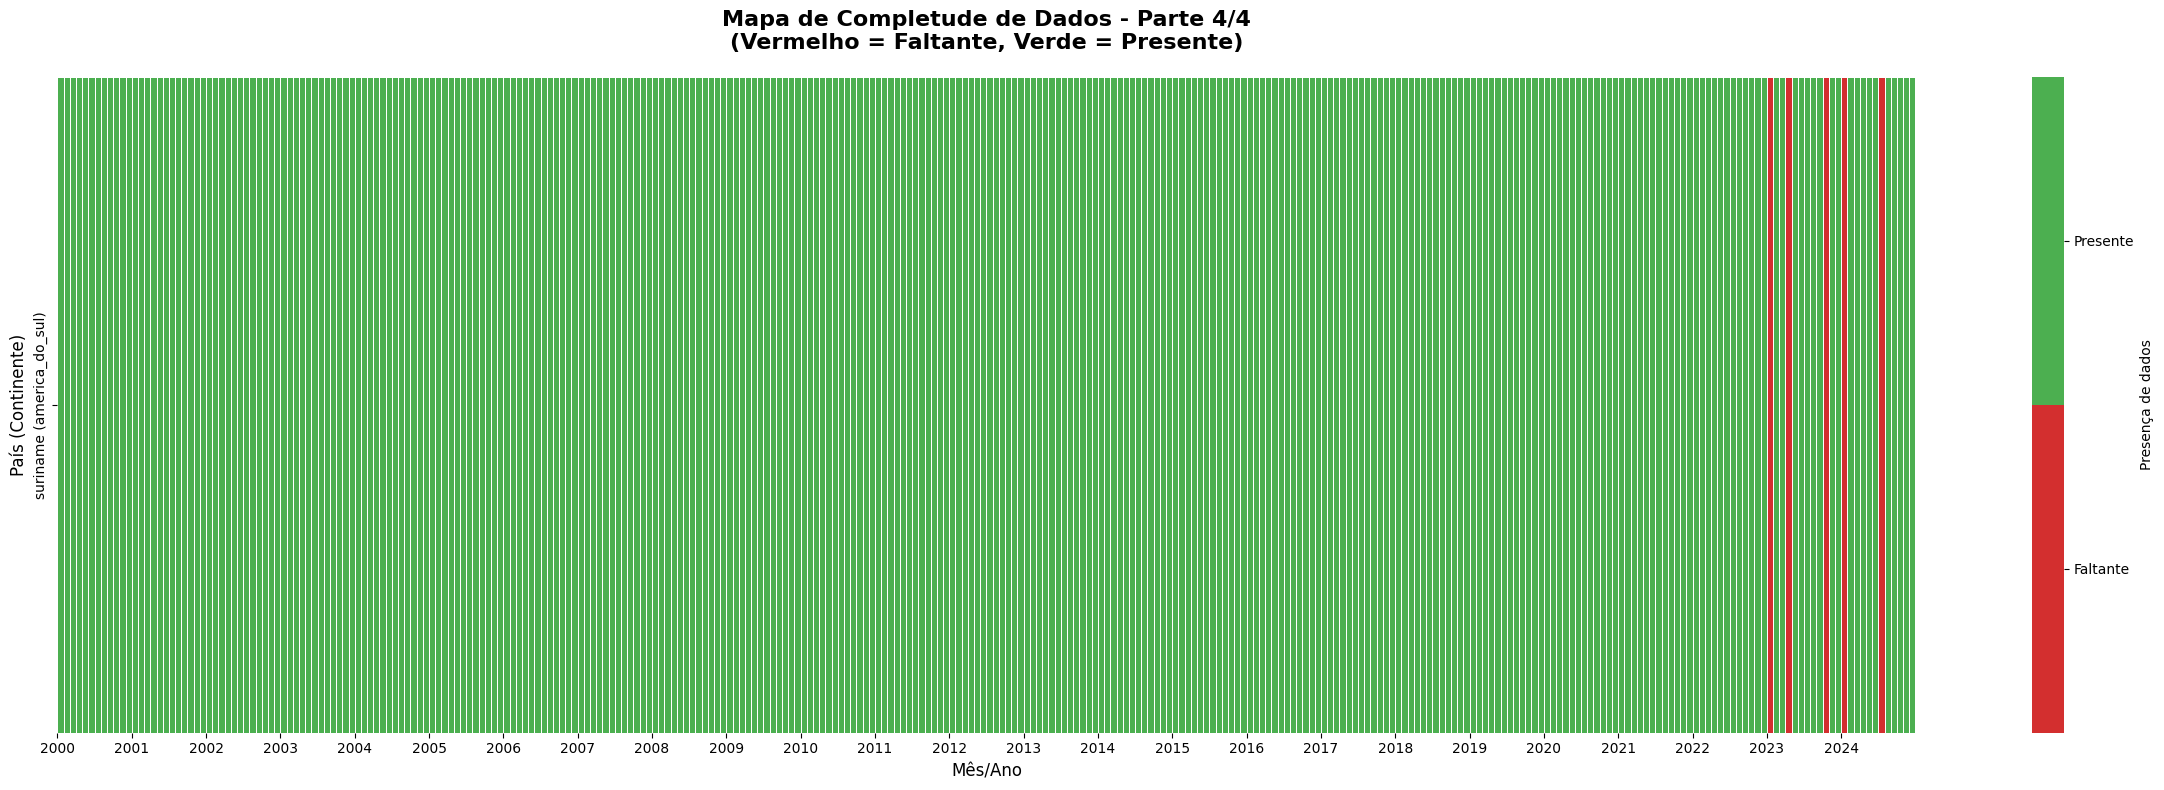

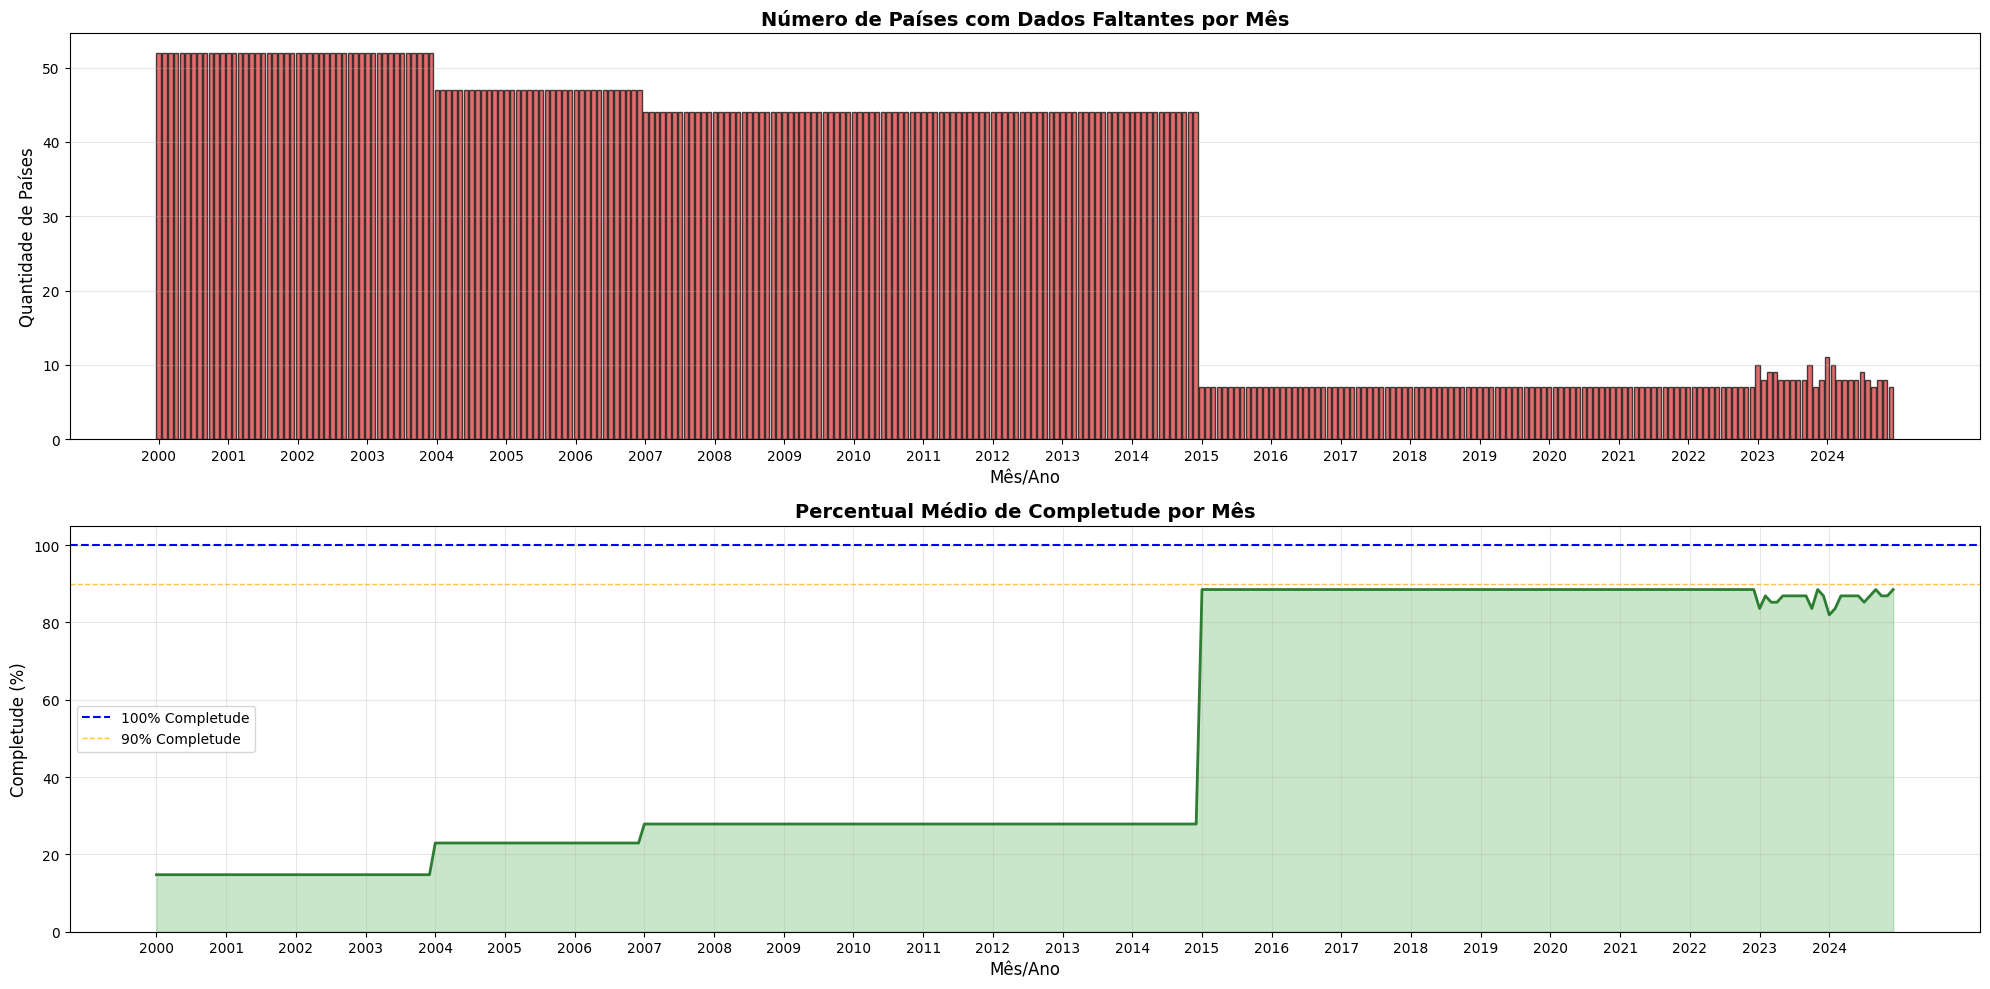

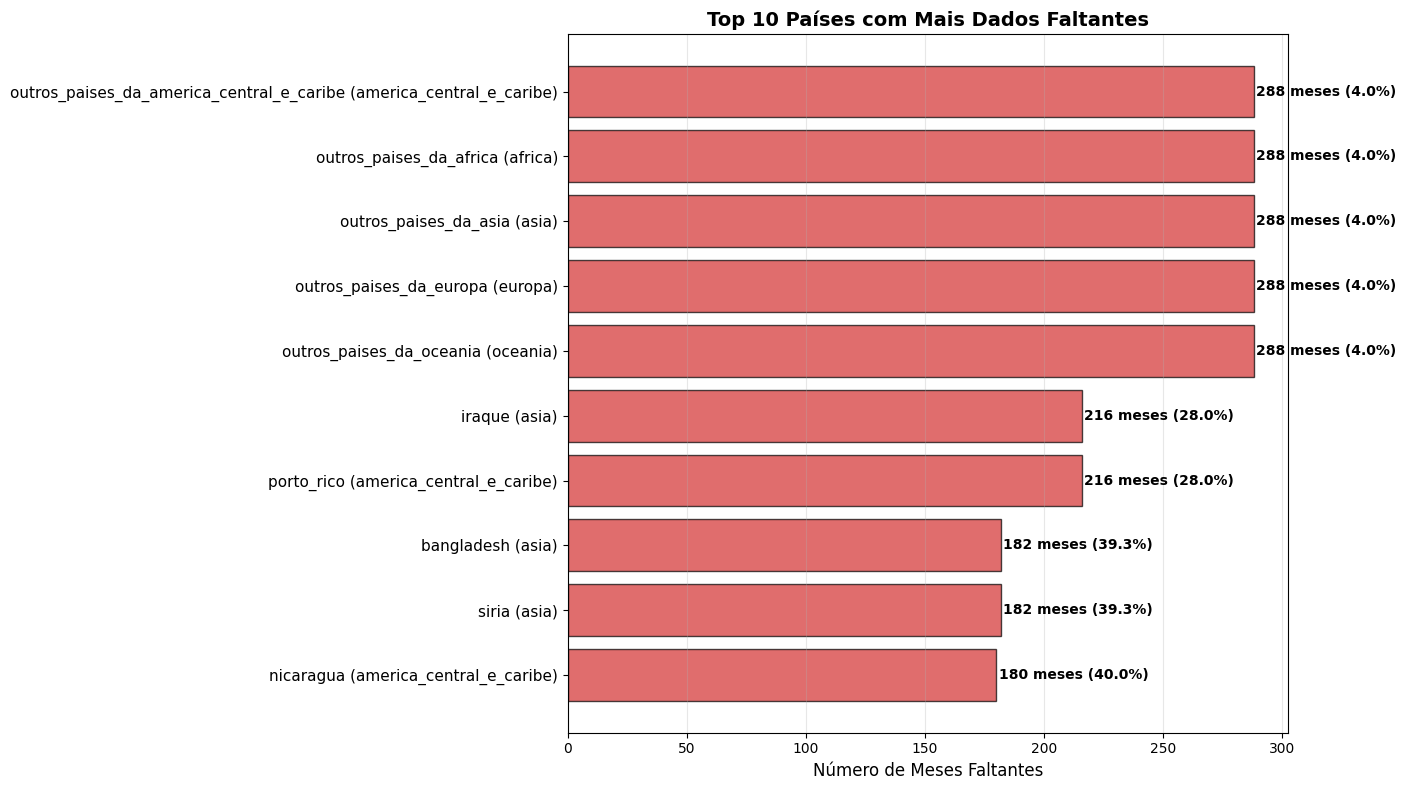

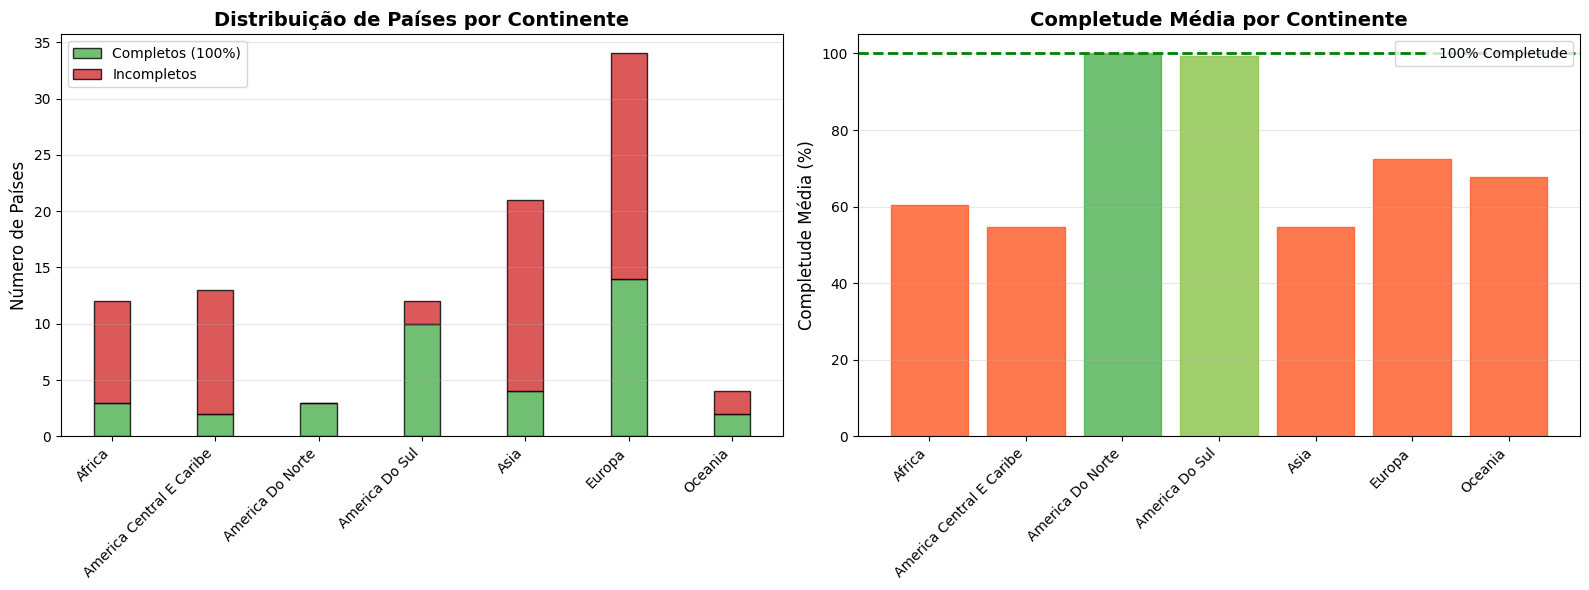


✓ Todas as visualizações foram criadas

Resumo:
  • Países com dados faltantes: 61
  • Total de gaps identificados: 9,285 registros
  • Período analisado: 300 meses
  • Completude geral: 49.26%


In [5]:
# ========================================
# VISUALIZAÇÃO DE DADOS FALTANTES POR PAÍS
# ========================================

print("="*80)
print("VISUALIZAÇÃO DE LAPSOS TEMPORAIS POR PAÍS")
print("="*80 + "\n")

# Filtrar apenas países com dados faltantes
incomplete_countries = country_analysis[country_analysis['Missing_Records'] > 0].copy()
incomplete_countries = incomplete_countries.sort_values('Missing_Records', ascending=False)

if len(incomplete_countries) == 0:
    print("✓ Todos os países têm 100% de completude - sem gráficos para mostrar")
else:
    print(f"Total de países com dados faltantes: {len(incomplete_countries)}\n")
    
    # Criar DataFrame para heatmap
    all_dates_set = set(date_range)
    
    # Para cada país, criar série temporal indicando presença (1) ou ausência (0)
    presence_data = []
    country_labels = []
    
    for (continent, country), row in incomplete_countries.iterrows():
        # Datas existentes
        country_dates = df_rj_countries[
            (df_rj_countries['country'] == country) &
            (df_rj_countries['continent'] == continent)
        ]['date'].values
        
        country_dates_set = set(pd.to_datetime(country_dates))
        
        # Criar série: 1 se tem dado, 0 se falta
        presence = [1 if date in country_dates_set else 0 for date in date_range]
        presence_data.append(presence)
        country_labels.append(f"{country} ({continent})")
    
    # Criar DataFrame
    df_presence = pd.DataFrame(
        presence_data,
        index=country_labels,
        columns=[d.strftime('%Y-%m') for d in date_range]
    )
    
    # ========================================
    # GRÁFICO 1: HEATMAP GERAL
    # ========================================
    n_countries = len(incomplete_countries)
    
    if n_countries <= 20:
        # Se poucos países, mostrar todos em um gráfico
        fig, ax = plt.subplots(figsize=(24, max(8, n_countries * 0.4)))
        
        sns.heatmap(
            df_presence,
            cmap=['#d32f2f', '#4caf50'],  # Vermelho = falta, Verde = presente
            cbar_kws={'label': 'Presença de dados', 'ticks': [0, 1]},
            linewidths=0.5,
            linecolor='white',
            ax=ax
        )
        
        ax.set_title('Mapa de Completude de Dados por País\n(Vermelho = Dado Faltante, Verde = Dado Presente)', 
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Mês/Ano', fontsize=12)
        ax.set_ylabel('País (Continente)', fontsize=12)
        
        # Ajustar labels do eixo X para mostrar apenas anos
        xticks_positions = range(0, len(date_range), 12)  # A cada 12 meses
        xticks_labels = [date_range[i].strftime('%Y') for i in xticks_positions]
        ax.set_xticks(xticks_positions)
        ax.set_xticklabels(xticks_labels, rotation=0)
        
        # Colorbar customizada
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.25, 0.75])
        cbar.set_ticklabels(['Faltante', 'Presente'])
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Se muitos países, dividir em múltiplos gráficos
        countries_per_plot = 20
        n_plots = (n_countries + countries_per_plot - 1) // countries_per_plot
        
        for plot_idx in range(n_plots):
            start_idx = plot_idx * countries_per_plot
            end_idx = min((plot_idx + 1) * countries_per_plot, n_countries)
            
            df_subset = df_presence.iloc[start_idx:end_idx]
            
            fig, ax = plt.subplots(figsize=(24, max(8, len(df_subset) * 0.4)))
            
            sns.heatmap(
                df_subset,
                cmap=['#d32f2f', '#4caf50'],
                cbar_kws={'label': 'Presença de dados', 'ticks': [0, 1]},
                linewidths=0.5,
                linecolor='white',
                ax=ax
            )
            
            ax.set_title(f'Mapa de Completude de Dados - Parte {plot_idx + 1}/{n_plots}\n(Vermelho = Faltante, Verde = Presente)', 
                         fontsize=16, fontweight='bold', pad=20)
            ax.set_xlabel('Mês/Ano', fontsize=12)
            ax.set_ylabel('País (Continente)', fontsize=12)
            
            xticks_positions = range(0, len(date_range), 12)
            xticks_labels = [date_range[i].strftime('%Y') for i in xticks_positions]
            ax.set_xticks(xticks_positions)
            ax.set_xticklabels(xticks_labels, rotation=0)
            
            cbar = ax.collections[0].colorbar
            cbar.set_ticks([0.25, 0.75])
            cbar.set_ticklabels(['Faltante', 'Presente'])
            
            plt.tight_layout()
            plt.show()
    
    # ========================================
    # GRÁFICO 2: DISTRIBUIÇÃO TEMPORAL DE GAPS
    # ========================================
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    
    # 2.1: Total de países com dados faltantes por mês
    missing_by_month = (1 - df_presence).sum(axis=0)
    
    axes[0].bar(range(len(date_range)), missing_by_month.values, color='#d32f2f', alpha=0.7, edgecolor='black')
    axes[0].set_title('Número de Países com Dados Faltantes por Mês', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Mês/Ano', fontsize=12)
    axes[0].set_ylabel('Quantidade de Países', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    xticks_positions = range(0, len(date_range), 12)
    xticks_labels = [date_range[i].strftime('%Y') for i in xticks_positions]
    axes[0].set_xticks(xticks_positions)
    axes[0].set_xticklabels(xticks_labels, rotation=0)
    
    # 2.2: Percentual de completude por mês
    completeness_by_month = df_presence.mean(axis=0) * 100
    
    axes[1].fill_between(range(len(date_range)), completeness_by_month.values, 
                          color='#4caf50', alpha=0.3)
    axes[1].plot(range(len(date_range)), completeness_by_month.values, 
                 color='#2e7d32', linewidth=2)
    axes[1].axhline(y=100, color='blue', linestyle='--', linewidth=1.5, label='100% Completude')
    axes[1].axhline(y=90, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='90% Completude')
    
    axes[1].set_title('Percentual Médio de Completude por Mês', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Mês/Ano', fontsize=12)
    axes[1].set_ylabel('Completude (%)', fontsize=12)
    axes[1].set_ylim([0, 105])
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=10)
    axes[1].set_xticks(xticks_positions)
    axes[1].set_xticklabels(xticks_labels, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # GRÁFICO 3: PAÍSES MAIS PROBLEMÁTICOS (Top 10)
    # ========================================
    top_10_incomplete = incomplete_countries.head(10)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    countries_names = [f"{country} ({continent})" for (continent, country), _ in top_10_incomplete.iterrows()]
    missing_counts = top_10_incomplete['Missing_Records'].values
    completeness_pct = top_10_incomplete['Completeness_%'].values
    
    bars = ax.barh(range(len(countries_names)), missing_counts, color='#d32f2f', alpha=0.7, edgecolor='black')
    
    # Adicionar valores nas barras
    for i, (count, pct) in enumerate(zip(missing_counts, completeness_pct)):
        ax.text(count + 1, i, f'{count} meses ({pct:.1f}%)', 
                va='center', fontsize=10, fontweight='bold')
    
    ax.set_yticks(range(len(countries_names)))
    ax.set_yticklabels(countries_names, fontsize=11)
    ax.invert_yaxis()
    ax.set_xlabel('Número de Meses Faltantes', fontsize=12)
    ax.set_title('Top 10 Países com Mais Dados Faltantes', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # GRÁFICO 4: DISTRIBUIÇÃO POR CONTINENTE
    # ========================================
    continent_stats = []
    
    for continent in sorted(df_rj_countries['continent'].unique()):
        continent_countries = country_analysis.loc[
            country_analysis.index.get_level_values('continent') == continent
        ]
        
        total_countries = len(continent_countries)
        incomplete_count = (continent_countries['Missing_Records'] > 0).sum()
        avg_completeness = continent_countries['Completeness_%'].mean()
        
        continent_stats.append({
            'continent': continent.replace('_', ' ').title(),
            'total': total_countries,
            'incomplete': incomplete_count,
            'complete': total_countries - incomplete_count,
            'avg_completeness': avg_completeness
        })
    
    df_cont_stats = pd.DataFrame(continent_stats)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 4.1: Países completos vs incompletos
    x = range(len(df_cont_stats))
    width = 0.35
    
    axes[0].bar(x, df_cont_stats['complete'], width, label='Completos (100%)', 
                color='#4caf50', alpha=0.8, edgecolor='black')
    axes[0].bar(x, df_cont_stats['incomplete'], width, bottom=df_cont_stats['complete'],
                label='Incompletos', color='#d32f2f', alpha=0.8, edgecolor='black')
    
    axes[0].set_ylabel('Número de Países', fontsize=12)
    axes[0].set_title('Distribuição de Países por Continente', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(df_cont_stats['continent'], rotation=45, ha='right')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 4.2: Completude média por continente
    bars = axes[1].bar(x, df_cont_stats['avg_completeness'], 
                       color='#2196f3', alpha=0.8, edgecolor='black')
    
    # Adicionar linha de 100%
    axes[1].axhline(y=100, color='green', linestyle='--', linewidth=2, label='100% Completude')
    
    # Colorir barras baseado no nível de completude
    for i, bar in enumerate(bars):
        completeness = df_cont_stats.loc[i, 'avg_completeness']
        if completeness == 100:
            bar.set_color('#4caf50')
        elif completeness >= 95:
            bar.set_color('#8bc34a')
        elif completeness >= 90:
            bar.set_color('#ffc107')
        else:
            bar.set_color('#ff5722')
    
    axes[1].set_ylabel('Completude Média (%)', fontsize=12)
    axes[1].set_title('Completude Média por Continente', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(df_cont_stats['continent'], rotation=45, ha='right')
    axes[1].set_ylim([0, 105])
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Todas as visualizações foram criadas")
    print(f"\nResumo:")
    print(f"  • Países com dados faltantes: {len(incomplete_countries)}")
    print(f"  • Total de gaps identificados: {incomplete_countries['Missing_Records'].sum():,} registros")
    print(f"  • Período analisado: {len(date_range)} meses")
    print(f"  • Completude geral: {(1 - incomplete_countries['Missing_Records'].sum() / (len(incomplete_countries) * len(date_range))) * 100:.2f}%")

In [6]:
df

,continent,continent_id,country,country_id,state,state_id,entry_route,entry_route_id,year,month,month_id,arrivals,file_index,date
0,africa,1,africa_do_sul,2,amazonas,4,aereo,1,2000,janeiro,1,0.0,file_0,2000-01-01
1,africa,1,angola,6,amazonas,4,aereo,1,2000,janeiro,1,0.0,file_0,2000-01-01
2,africa,1,nigeria,162,amazonas,4,aereo,1,2000,janeiro,1,0.0,file_0,2000-01-01
3,africa,1,outros_paises,998,amazonas,4,aereo,1,2000,janeiro,1,3.0,file_0,2000-01-01
4,america_central_e_caribe,2,costa_rica,53,amazonas,4,aereo,1,2000,janeiro,1,0.0,file_0,2000-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762567,europa,6,suica,86,rio_grande_do_sul,21,fluvial,4,2024,dezembro,12,3.0,file_24,2024-12-01
762568,america_do_sul,4,uruguai,36,rio_grande_do_sul,21,fluvial,4,2024,dezembro,12,6.0,file_24,2024-12-01
762569,america_do_sul,4,argentina,26,santa_catarina,24,fluvial,4,2024,dezembro,12,120.0,file_24,2024-12-01
762570,america_do_sul,4,chile,28,santa_catarina,24,fluvial,4,2024,dezembro,12,3.0,file_24,2024-12-01


In [7]:

# Função que ajusta os nomes "outros_paises" no contexto do continente
def ajustar_outros_paises(row):
    nome_pais = row["country"]
    continente = row["continent"]
    
    # Se for algum tipo de "outros_paises", sempre padroniza
    if nome_pais.startswith("outros_paises"):
        return f"outros_paises_da_{continente.lower()}"
    return nome_pais
# Aplica renomeação
df = df.loc[df["state"] == "rio_de_janeiro"]

df["country"] = df.apply(ajustar_outros_paises, axis=1)

df_rj_countries = process_df(
    df=df, 
    state="rio_de_janeiro", 
    agg_cols=["date", "continent", "country"], 
    value_cols="arrivals", 
    agg_func="sum"
)


C:\Users\f0oo\AppData\Local\Temp\ipykernel_19812\3718433325.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["country"] = df.apply(ajustar_outros_paises, axis=1)


In [8]:
df_rj_countries['country'].unique()

array(['africa_do_sul', 'angola', 'nigeria', 'outros_paises_da_africa',
       'costa_rica', 'outros_paises_da_america_central_e_caribe',
       'panama', 'porto_rico', 'canada', 'estados_unidos', 'mexico',
       'argentina', 'bolivia', 'chile', 'colombia', 'equador', 'guiana',
       'guiana_francesa', 'paraguai', 'peru', 'suriname', 'uruguai',
       'venezuela', 'arabia_saudita', 'china', 'iraque', 'israel',
       'japao', 'outros_paises_da_asia', 'republica_da_coreia',
       'alemanha', 'austria', 'belgica', 'dinamarca', 'espanha', 'franca',
       'grecia', 'holanda', 'italia', 'noruega',
       'outros_paises_da_europa', 'portugal', 'reino_unido', 'suecia',
       'suica', 'australia', 'nova_zelandia', 'cabo_verde', 'finlandia',
       'hungria', 'irlanda', 'polonia', 'cuba', 'guatemala', 'india',
       'republica_tcheca', 'russia', 'outros_paises_da_oceania', 'egito',
       'gana', 'marrocos', 'mocambique', 'quenia', 'tunisia',
       'el_salvador', 'haiti', 'honduras', 'ni

In [9]:
country_analysis = df_rj_countries.groupby(['continent', 'country']).agg({
    'date': 'count',  # Número de registros
    'arrivals': ['sum', lambda x: (x == 0).sum(), lambda x: x.isna().sum()]
}).round(2)

country_analysis.columns = ['N_Records', 'Total_Arrivals', 'Zero_Count', 'Null_Count']

# Adicionar métricas de completude
country_analysis['Expected_Records'] = total_months
country_analysis['Missing_Records'] = total_months - country_analysis['N_Records']
country_analysis['Completeness_%'] = (country_analysis['N_Records'] / total_months * 100).round(2)
country_analysis['Zero_%'] = (country_analysis['Zero_Count'] / country_analysis['N_Records'] * 100).round(2)

# Ordenar por completude
country_analysis = country_analysis.sort_values('Completeness_%', ascending=False)

# Mostrar todos os países
print(country_analysis.to_string())

# ========================================
# 2. ESTATÍSTICAS GERAIS
# ========================================
print("\n" + "="*80)
print("2. ESTATÍSTICAS GERAIS")
print("="*80 + "\n")

print(f"Total de países: {len(country_analysis)}")
print(f"Países com 100% de completude: {(country_analysis['Completeness_%'] == 100).sum()}")
print(f"Países com dados faltantes: {(country_analysis['Missing_Records'] > 0).sum()}")
print(f"Países com valores zero: {(country_analysis['Zero_Count'] > 0).sum()}")
print(f"Países com valores nulos: {(country_analysis['Null_Count'] > 0).sum()}")

print(f"\nCompletude média: {country_analysis['Completeness_%'].mean():.2f}%")
print(f"Completude mínima: {country_analysis['Completeness_%'].min():.2f}%")
print(f"Completude máxima: {country_analysis['Completeness_%'].max():.2f}%")

# ========================================
# 3. PAÍSES COM PROBLEMAS
# ========================================
print("\n" + "="*80)
print("3. PAÍSES COM DADOS PROBLEMÁTICOS")
print("="*80 + "\n")

# Países com menos de 100% de completude
incomplete = country_analysis[country_analysis['Completeness_%'] < 100].copy()

if len(incomplete) > 0:
    print(f"--- PAÍSES COM DADOS FALTANTES ({len(incomplete)} países) ---\n")
    print(incomplete[['N_Records', 'Expected_Records', 'Missing_Records', 'Completeness_%']].to_string())
    
    # Mostrar quantos meses faltam para cada
    print(f"\nResumo de dados faltantes:")
    print(f"  Média de meses faltantes: {incomplete['Missing_Records'].mean():.2f}")
    print(f"  Máximo de meses faltantes: {incomplete['Missing_Records'].max()}")
    print(f"  Países com >12 meses faltantes: {(incomplete['Missing_Records'] > 12).sum()}")
    print(f"  Países com >24 meses faltantes: {(incomplete['Missing_Records'] > 24).sum()}")
else:
    print("✓ Todos os países têm 100% de completude temporal")

# Países com muitos zeros
high_zeros = country_analysis[country_analysis['Zero_%'] > 10].copy()

if len(high_zeros) > 0:
    print(f"\n--- PAÍSES COM >10% DE VALORES ZERO ({len(high_zeros)} países) ---\n")
    print(high_zeros[['N_Records', 'Zero_Count', 'Zero_%', 'Total_Arrivals']].to_string())
    
    print(f"\nResumo de zeros:")
    print(f"  Média de % de zeros: {high_zeros['Zero_%'].mean():.2f}%")
    print(f"  Máximo de % de zeros: {high_zeros['Zero_%'].max():.2f}%")
    print(f"  Países com >50% zeros: {(high_zeros['Zero_%'] > 50).sum()}")
else:
    print("\n✓ Nenhum país tem mais de 10% de valores zero")

# ========================================
# 4. ANÁLISE POR CONTINENTE
# ========================================
print("\n" + "="*80)
print("4. COMPLETUDE POR CONTINENTE")
print("="*80 + "\n")

for continent in sorted(df_rj_countries['continent'].unique()):
    print(f"\n{'='*80}")
    print(f"CONTINENTE: {continent.upper().replace('_', ' ')}")
    print(f"{'='*80}\n")
    
    # Filtrar países do continente
    continent_countries = country_analysis.loc[
        country_analysis.index.get_level_values('continent') == continent
    ].copy()
    
    print(f"Total de países: {len(continent_countries)}")
    print(f"Completude média: {continent_countries['Completeness_%'].mean():.2f}%")
    print(f"Países com 100% completude: {(continent_countries['Completeness_%'] == 100).sum()}")
    print(f"Países com dados faltantes: {(continent_countries['Missing_Records'] > 0).sum()}")
    print(f"Países com >10% zeros: {(continent_countries['Zero_%'] > 10).sum()}")
    
    # Mostrar países com problemas neste continente
    problems = continent_countries[
        (continent_countries['Completeness_%'] < 100) | 
        (continent_countries['Zero_%'] > 10)
    ]
    
    if len(problems) > 0:
        print(f"\n⚠️  Países com problemas ({len(problems)}):\n")
        print(problems[['N_Records', 'Missing_Records', 'Completeness_%', 'Zero_Count', 'Zero_%']].to_string())
    else:
        print("\n✓ Todos os países neste continente estão OK")

# ========================================
# 5. PAÍSES ESPECÍFICOS COM GAPS (DETALHAMENTO)
# ========================================
print("\n" + "="*80)
print("5. DETALHAMENTO DE PAÍSES COM DADOS FALTANTES")
print("="*80 + "\n")

# Para cada país com dados faltantes, mostrar quais datas faltam
incomplete_countries = country_analysis[country_analysis['Missing_Records'] > 0].copy()
incomplete_countries = incomplete_countries.sort_values('Missing_Records', ascending=False)

if len(incomplete_countries) > 0:
    print(f"Total de países com dados faltantes: {len(incomplete_countries)}")
    print(f"\nMostrando os 10 países com mais dados faltantes:\n")
    
    for idx, ((continent, country), row) in enumerate(incomplete_countries.head(10).iterrows(), 1):
        print(f"\n{'-'*80}")
        print(f"{idx}. {country.upper()} ({continent.replace('_', ' ').title()})")
        print(f"{'-'*80}")
        
        # Datas existentes para este país
        country_dates = df_rj_countries[
            (df_rj_countries['country'] == country) &
            (df_rj_countries['continent'] == continent)
        ]['date'].values
        
        country_dates_set = set(pd.to_datetime(country_dates))
        
        # Datas faltantes
        all_dates_set = set(date_range)
        missing_dates = sorted(all_dates_set - country_dates_set)
        
        print(f"Registros existentes: {row['N_Records']} / {total_months}")
        print(f"Registros faltantes: {len(missing_dates)}")
        print(f"Valores zero: {row['Zero_Count']} ({row['Zero_%']:.1f}%)")
        
        if len(missing_dates) > 0:
            # Mostrar primeiras e últimas datas faltantes
            if len(missing_dates) <= 10:
                print(f"Datas faltantes: {[d.strftime('%Y-%m') for d in missing_dates]}")
            else:
                print(f"Primeiras 5 datas faltantes: {[d.strftime('%Y-%m') for d in missing_dates[:5]]}")
                print(f"Últimas 5 datas faltantes: {[d.strftime('%Y-%m') for d in missing_dates[-5:]]}")
            
            # Verificar se é um gap contínuo ou esparso
            if len(missing_dates) > 1:
                date_diffs = [(missing_dates[i+1] - missing_dates[i]).days for i in range(len(missing_dates)-1)]
                avg_gap = np.mean(date_diffs)
                
                if avg_gap < 35:  # ~1 mês
                    gap_type = "CONTÍNUO (período sem dados)"
                else:
                    gap_type = "ESPARSO (dados faltantes pontuais)"
                
                print(f"Tipo de gap: {gap_type}")
                print(f"Gap médio entre datas faltantes: {avg_gap:.1f} dias")
else:
    print("✓ Todos os países têm 100% de completude")

# ========================================
# 6. DISTRIBUIÇÃO TEMPORAL DE PROBLEMAS
# ========================================
print("\n" + "="*80)
print("6. DISTRIBUIÇÃO TEMPORAL DE PROBLEMAS")
print("="*80 + "\n")

# Contar quantos países têm zeros em cada mês
temporal_zeros = df_rj_countries[df_rj_countries['arrivals'] == 0].groupby('date').size()

if len(temporal_zeros) > 0:
    print(f"Meses com pelo menos um país com zero chegadas: {len(temporal_zeros)}")
    print(f"\nTop 10 meses com mais países com zero:\n")
    
    for date, count in temporal_zeros.sort_values(ascending=False).head(10).items():
        total_countries_that_month = len(df_rj_countries[df_rj_countries['date'] == date])
        pct = (count / total_countries_that_month * 100)
        print(f"{date.strftime('%Y-%m')}: {count:>3} países com zero ({pct:>5.1f}% do total)")
else:
    print("✓ Nenhum mês tem países com zero chegadas")

print("\n" + "="*80)
print("✓ Análise de completude por país concluída")
print("="*80)

                                                                    N_Records  Total_Arrivals  Zero_Count  Null_Count  Expected_Records  Missing_Records  Completeness_%  Zero_%
continent                country                                                                                                                                                
africa                   africa_do_sul                                    300         66765.0          10           0               300                0          100.00    3.33
                         angola                                           300        219500.0          13           0               300                0          100.00    4.33
                         outros_paises_da_africa                          300         60646.0           6           0               300                0          100.00    2.00
america_central_e_caribe costa_rica                                       300         51194.0           7          

VISUALIZAÇÃO DE LAPSOS TEMPORAIS POR PAÍS

Total de países com dados faltantes: 52



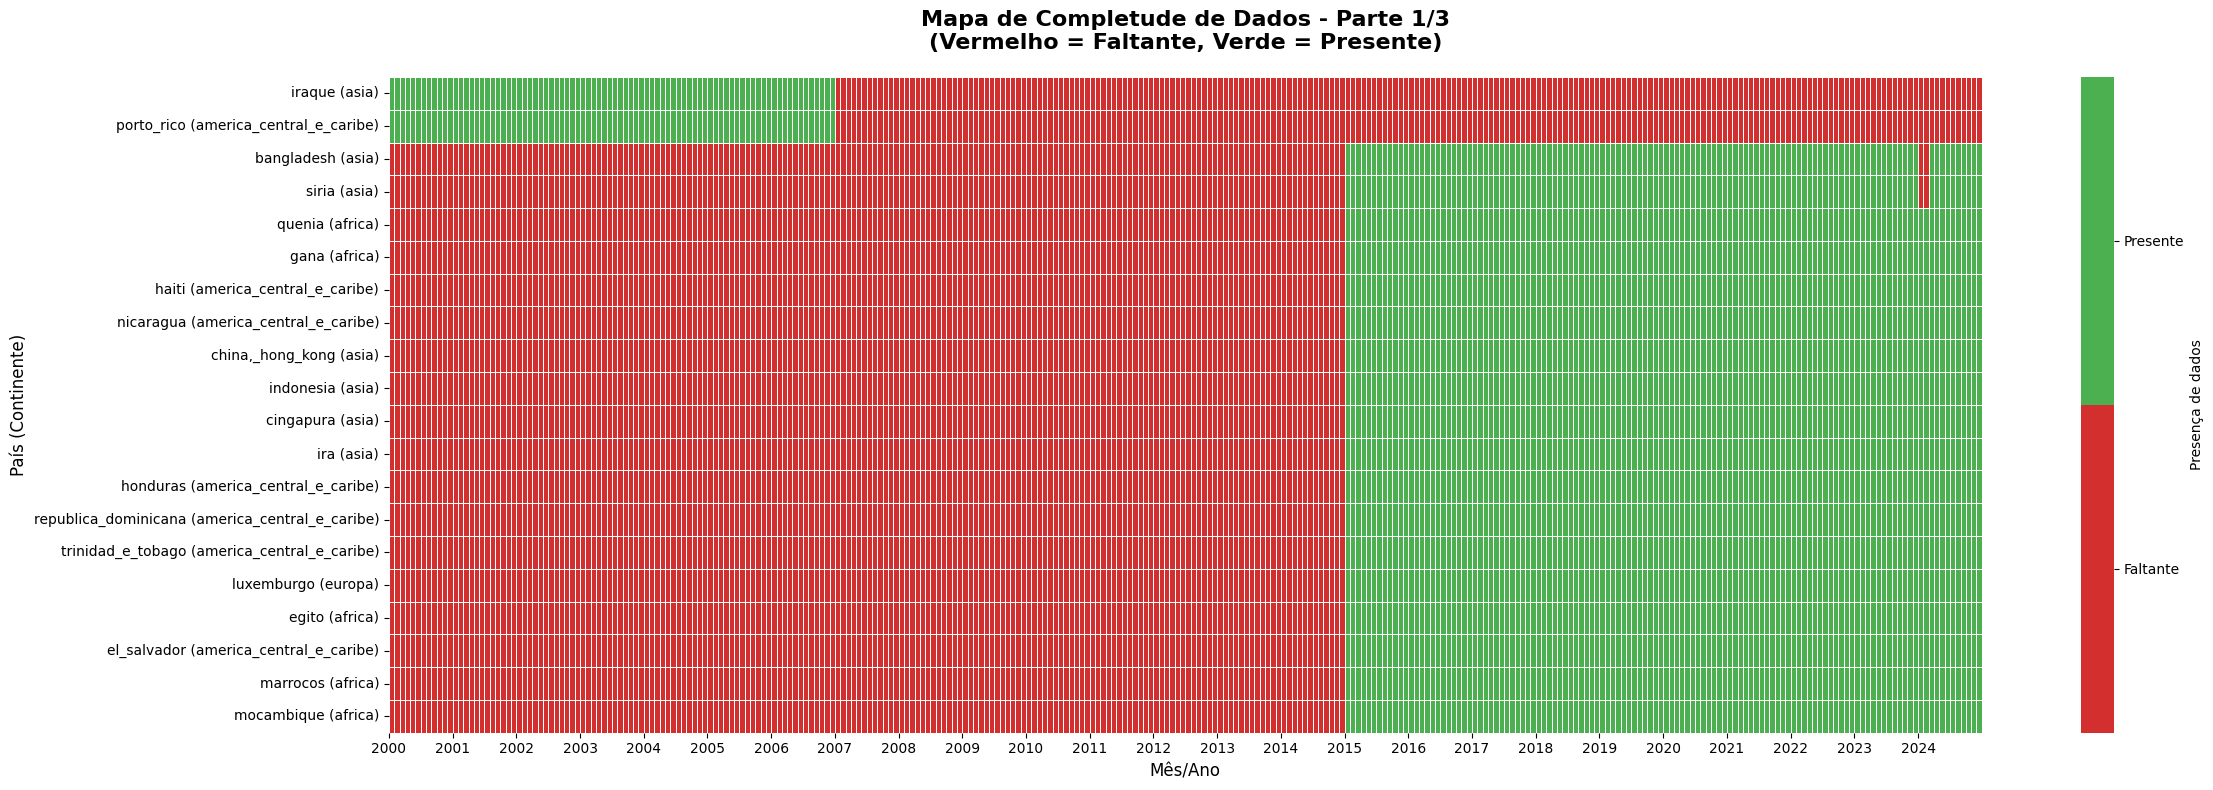

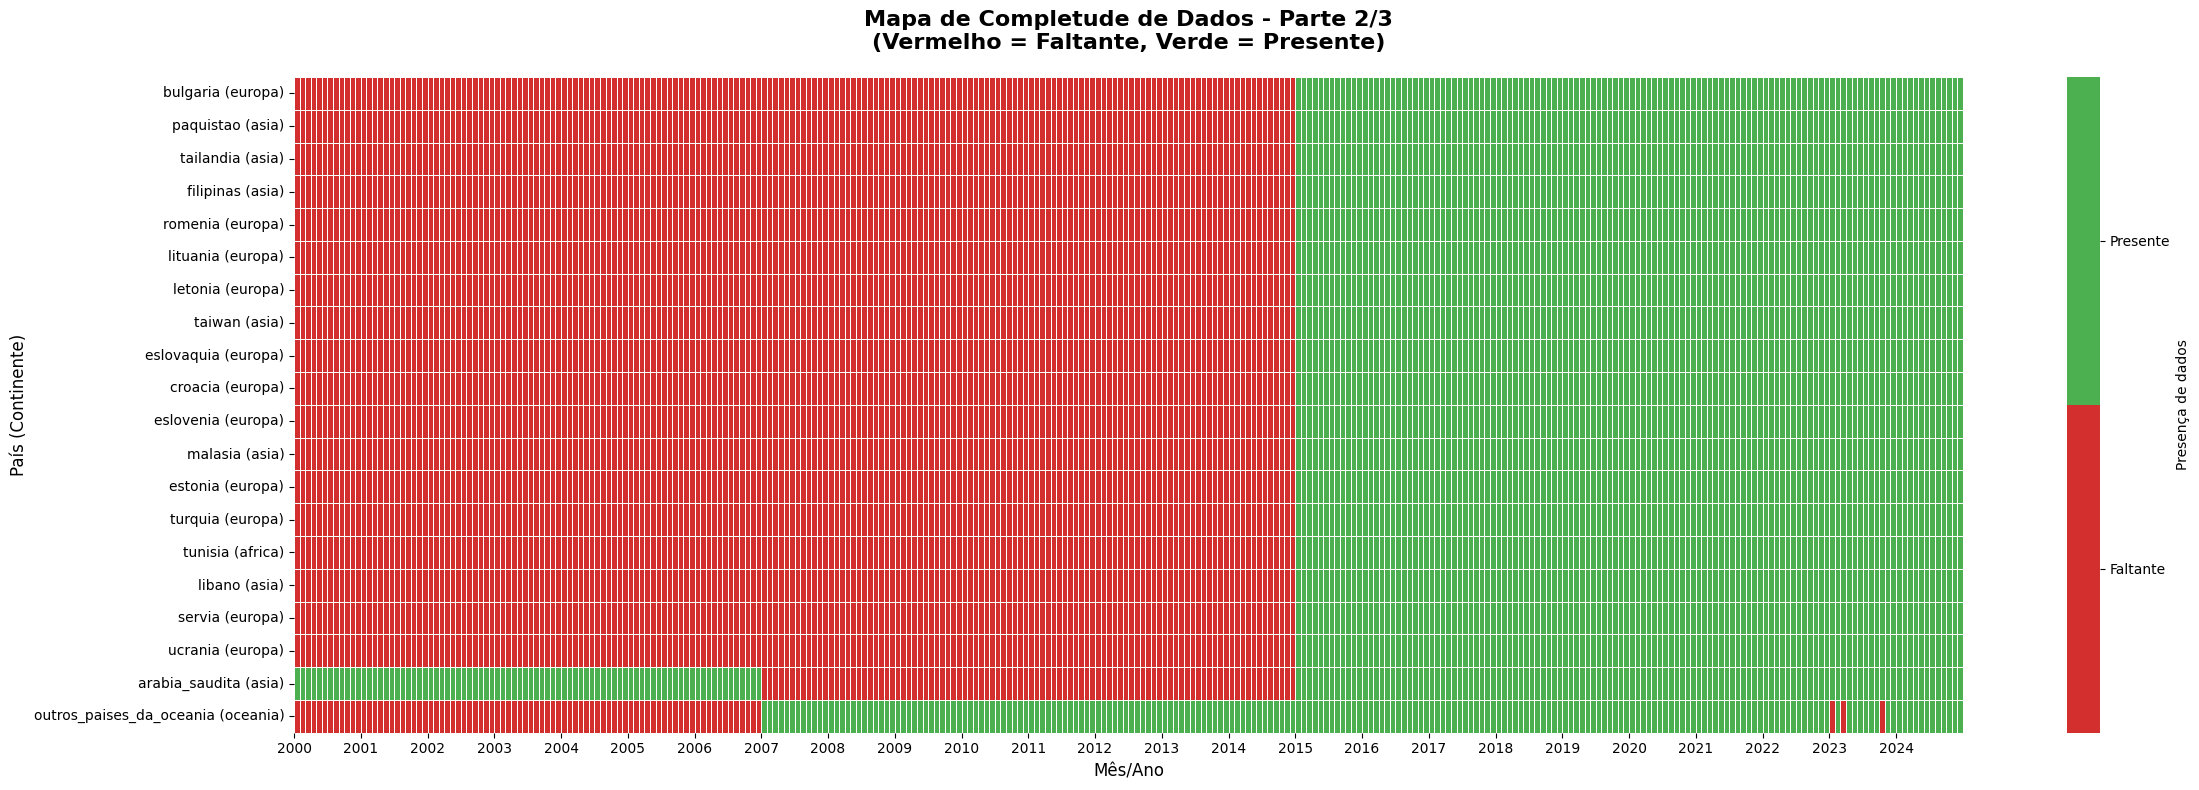

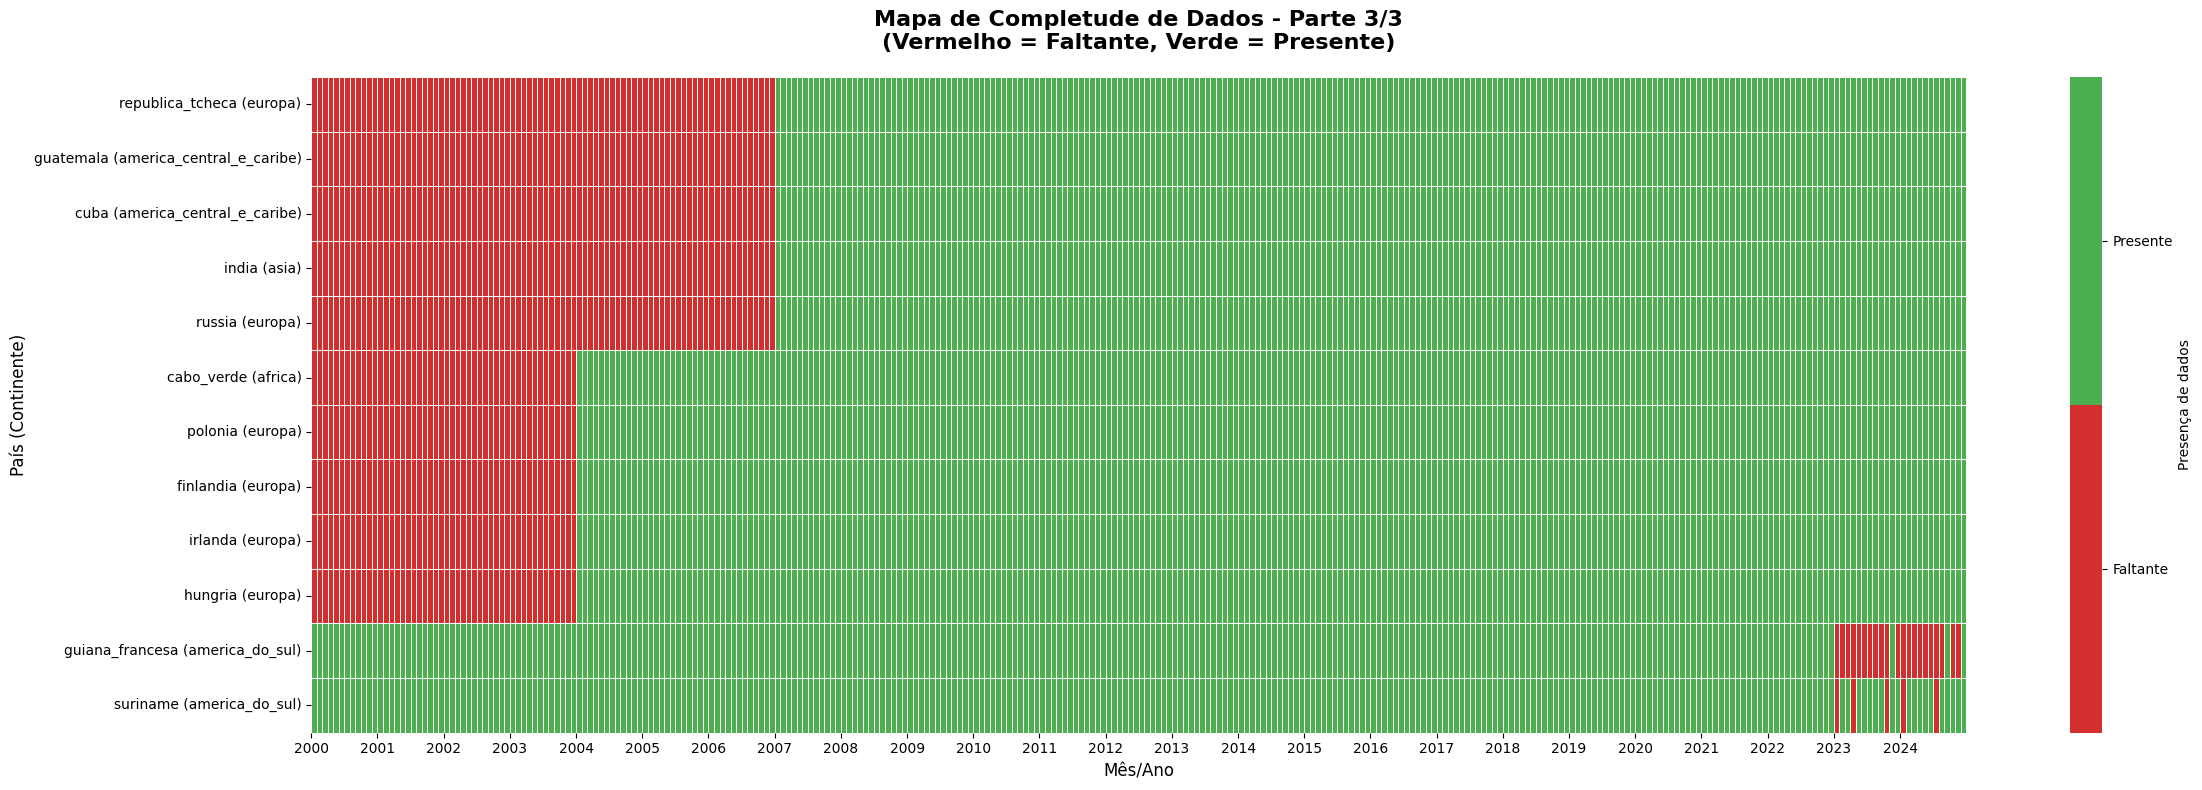

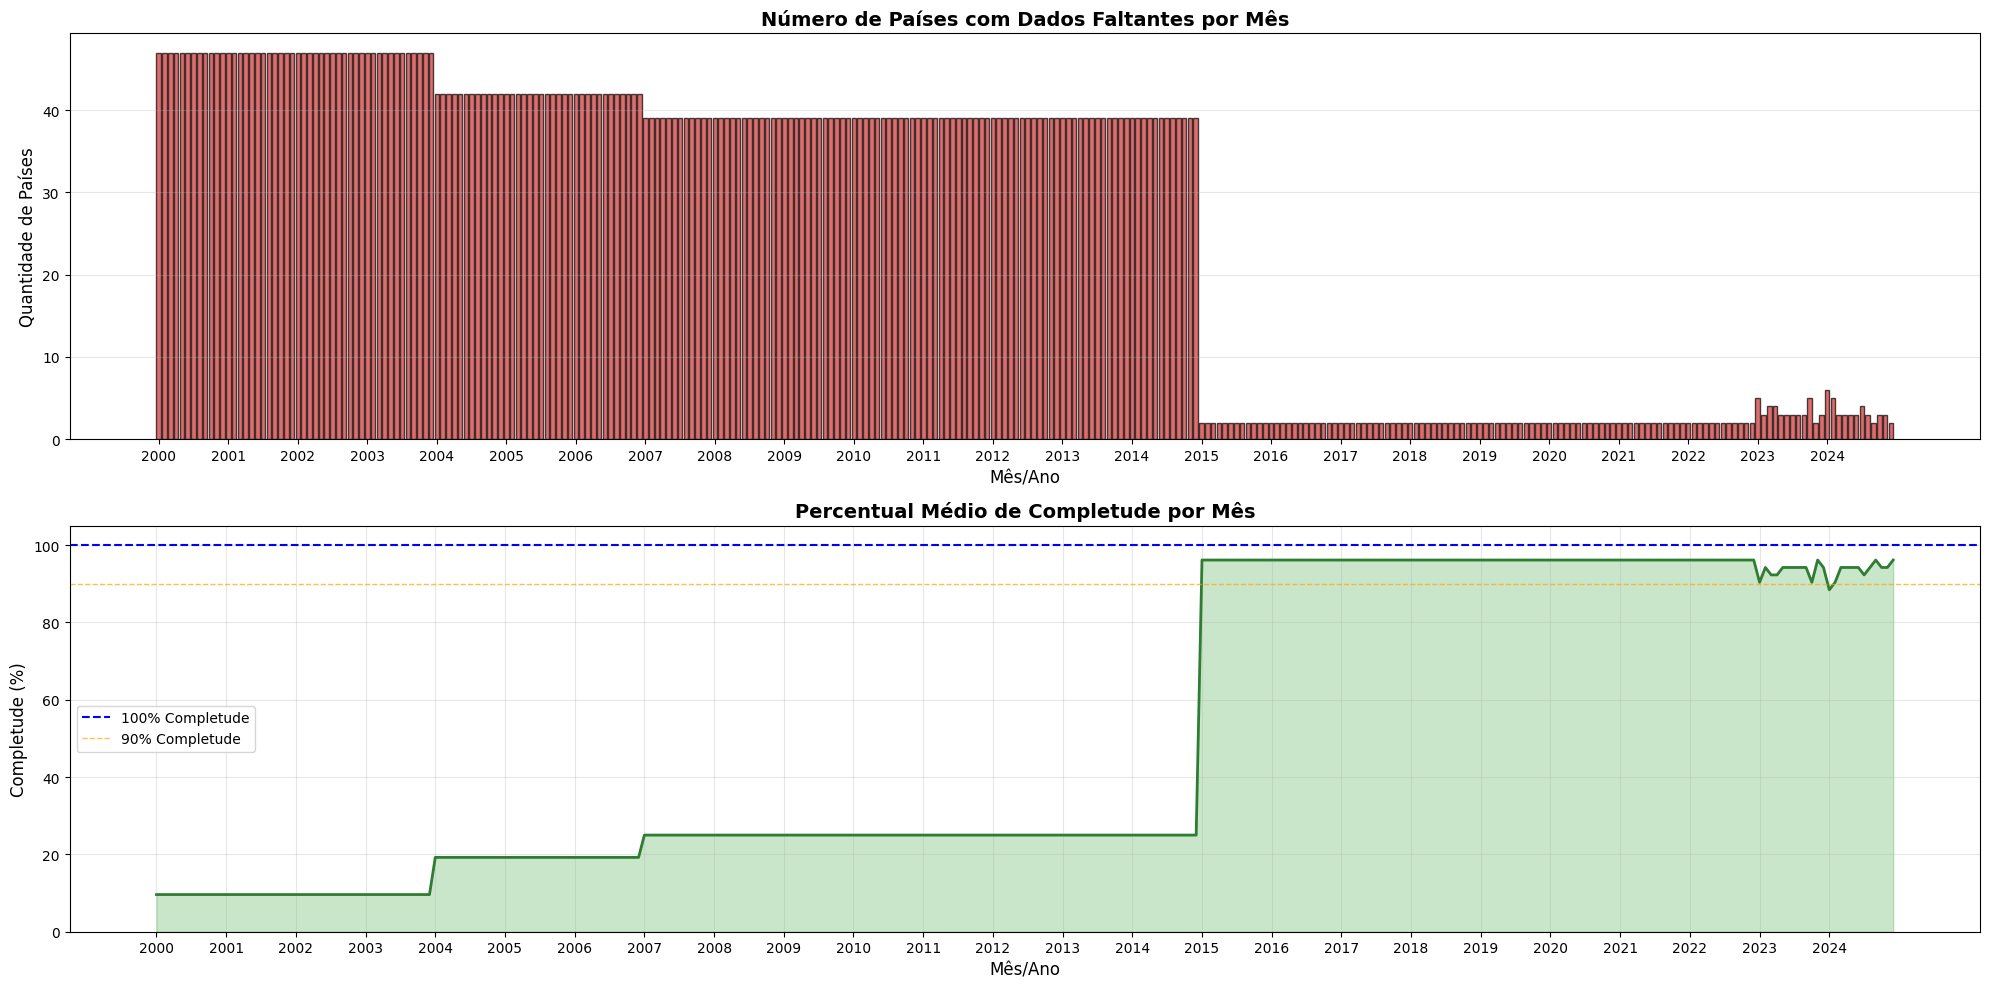

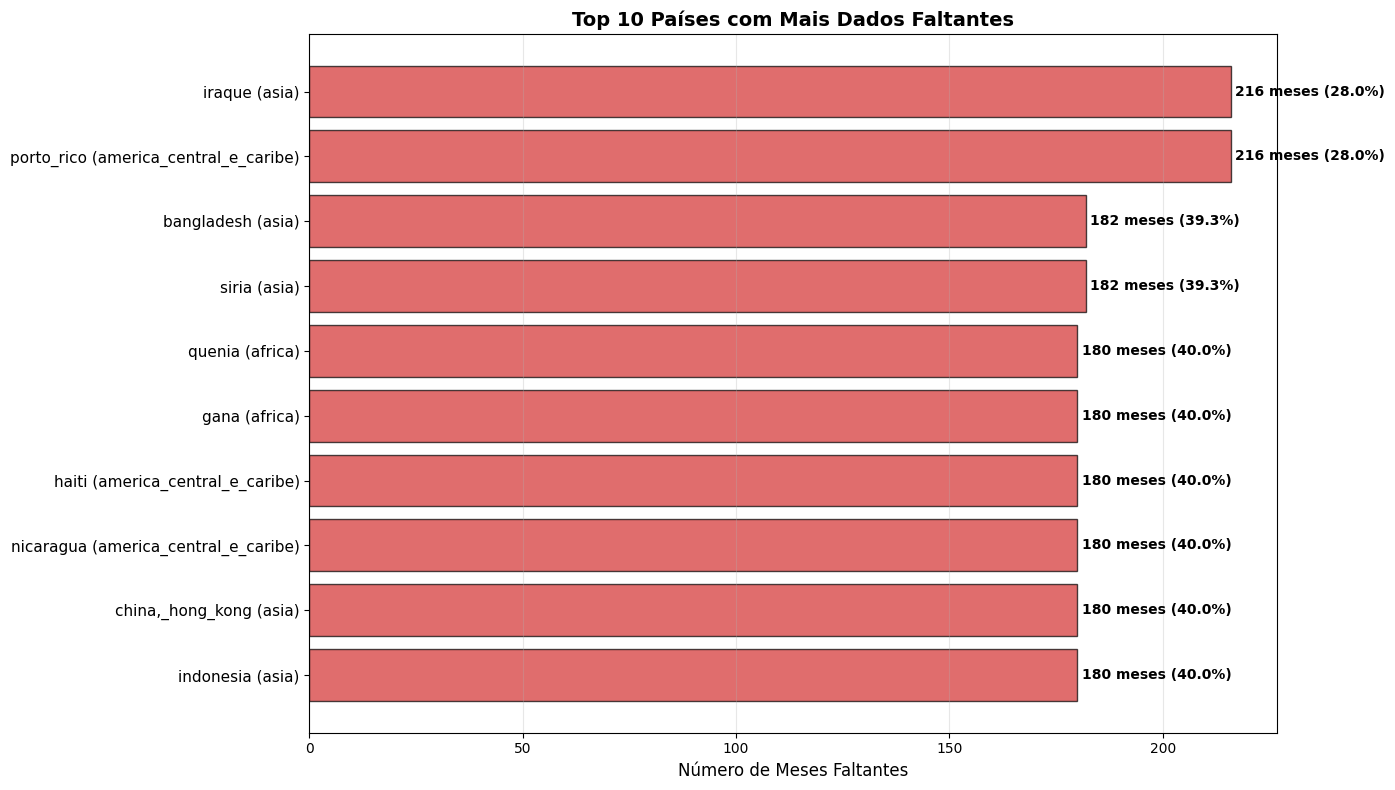

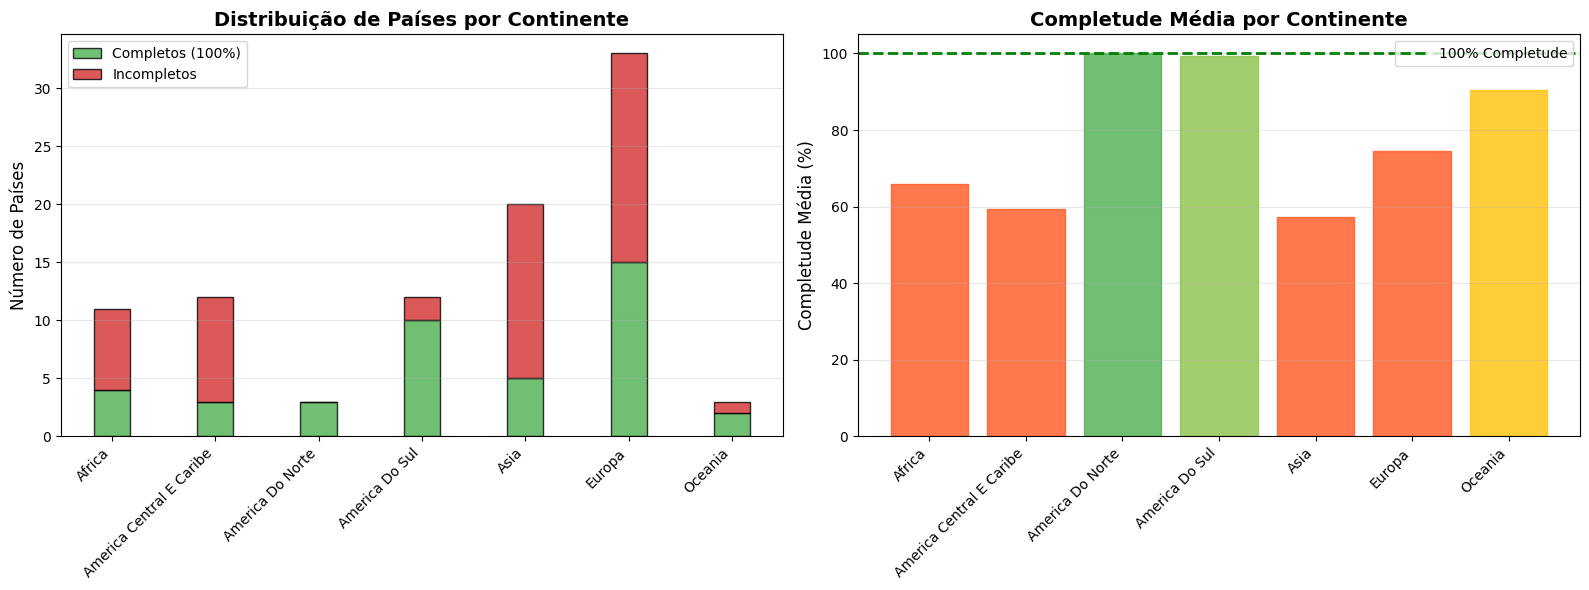


✓ Todas as visualizações foram criadas

Resumo:
  • Países com dados faltantes: 52
  • Total de gaps identificados: 7,785 registros
  • Período analisado: 300 meses
  • Completude geral: 50.10%


In [10]:
# ========================================
# VISUALIZAÇÃO DE DADOS FALTANTES POR PAÍS
# ========================================

print("="*80)
print("VISUALIZAÇÃO DE LAPSOS TEMPORAIS POR PAÍS")
print("="*80 + "\n")

# Filtrar apenas países com dados faltantes
incomplete_countries = country_analysis[country_analysis['Missing_Records'] > 0].copy()
incomplete_countries = incomplete_countries.sort_values('Missing_Records', ascending=False)

if len(incomplete_countries) == 0:
    print("✓ Todos os países têm 100% de completude - sem gráficos para mostrar")
else:
    print(f"Total de países com dados faltantes: {len(incomplete_countries)}\n")
    
    # Criar DataFrame para heatmap
    all_dates_set = set(date_range)
    
    # Para cada país, criar série temporal indicando presença (1) ou ausência (0)
    presence_data = []
    country_labels = []
    
    for (continent, country), row in incomplete_countries.iterrows():
        # Datas existentes
        country_dates = df_rj_countries[
            (df_rj_countries['country'] == country) &
            (df_rj_countries['continent'] == continent)
        ]['date'].values
        
        country_dates_set = set(pd.to_datetime(country_dates))
        
        # Criar série: 1 se tem dado, 0 se falta
        presence = [1 if date in country_dates_set else 0 for date in date_range]
        presence_data.append(presence)
        country_labels.append(f"{country} ({continent})")
    
    # Criar DataFrame
    df_presence = pd.DataFrame(
        presence_data,
        index=country_labels,
        columns=[d.strftime('%Y-%m') for d in date_range]
    )
    
    # ========================================
    # GRÁFICO 1: HEATMAP GERAL
    # ========================================
    n_countries = len(incomplete_countries)
    
    if n_countries <= 20:
        # Se poucos países, mostrar todos em um gráfico
        fig, ax = plt.subplots(figsize=(24, max(8, n_countries * 0.4)))
        
        sns.heatmap(
            df_presence,
            cmap=['#d32f2f', '#4caf50'],  # Vermelho = falta, Verde = presente
            cbar_kws={'label': 'Presença de dados', 'ticks': [0, 1]},
            linewidths=0.5,
            linecolor='white',
            ax=ax
        )
        
        ax.set_title('Mapa de Completude de Dados por País\n(Vermelho = Dado Faltante, Verde = Dado Presente)', 
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Mês/Ano', fontsize=12)
        ax.set_ylabel('País (Continente)', fontsize=12)
        
        # Ajustar labels do eixo X para mostrar apenas anos
        xticks_positions = range(0, len(date_range), 12)  # A cada 12 meses
        xticks_labels = [date_range[i].strftime('%Y') for i in xticks_positions]
        ax.set_xticks(xticks_positions)
        ax.set_xticklabels(xticks_labels, rotation=0)
        
        # Colorbar customizada
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([0.25, 0.75])
        cbar.set_ticklabels(['Faltante', 'Presente'])
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Se muitos países, dividir em múltiplos gráficos
        countries_per_plot = 20
        n_plots = (n_countries + countries_per_plot - 1) // countries_per_plot
        
        for plot_idx in range(n_plots):
            start_idx = plot_idx * countries_per_plot
            end_idx = min((plot_idx + 1) * countries_per_plot, n_countries)
            
            df_subset = df_presence.iloc[start_idx:end_idx]
            
            fig, ax = plt.subplots(figsize=(24, max(8, len(df_subset) * 0.4)))
            
            sns.heatmap(
                df_subset,
                cmap=['#d32f2f', '#4caf50'],
                cbar_kws={'label': 'Presença de dados', 'ticks': [0, 1]},
                linewidths=0.5,
                linecolor='white',
                ax=ax
            )
            
            ax.set_title(f'Mapa de Completude de Dados - Parte {plot_idx + 1}/{n_plots}\n(Vermelho = Faltante, Verde = Presente)', 
                         fontsize=16, fontweight='bold', pad=20)
            ax.set_xlabel('Mês/Ano', fontsize=12)
            ax.set_ylabel('País (Continente)', fontsize=12)
            
            xticks_positions = range(0, len(date_range), 12)
            xticks_labels = [date_range[i].strftime('%Y') for i in xticks_positions]
            ax.set_xticks(xticks_positions)
            ax.set_xticklabels(xticks_labels, rotation=0)
            
            cbar = ax.collections[0].colorbar
            cbar.set_ticks([0.25, 0.75])
            cbar.set_ticklabels(['Faltante', 'Presente'])
            
            plt.tight_layout()
            plt.show()
    
    # ========================================
    # GRÁFICO 2: DISTRIBUIÇÃO TEMPORAL DE GAPS
    # ========================================
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    
    # 2.1: Total de países com dados faltantes por mês
    missing_by_month = (1 - df_presence).sum(axis=0)
    
    axes[0].bar(range(len(date_range)), missing_by_month.values, color='#d32f2f', alpha=0.7, edgecolor='black')
    axes[0].set_title('Número de Países com Dados Faltantes por Mês', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Mês/Ano', fontsize=12)
    axes[0].set_ylabel('Quantidade de Países', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    xticks_positions = range(0, len(date_range), 12)
    xticks_labels = [date_range[i].strftime('%Y') for i in xticks_positions]
    axes[0].set_xticks(xticks_positions)
    axes[0].set_xticklabels(xticks_labels, rotation=0)
    
    # 2.2: Percentual de completude por mês
    completeness_by_month = df_presence.mean(axis=0) * 100
    
    axes[1].fill_between(range(len(date_range)), completeness_by_month.values, 
                          color='#4caf50', alpha=0.3)
    axes[1].plot(range(len(date_range)), completeness_by_month.values, 
                 color='#2e7d32', linewidth=2)
    axes[1].axhline(y=100, color='blue', linestyle='--', linewidth=1.5, label='100% Completude')
    axes[1].axhline(y=90, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='90% Completude')
    
    axes[1].set_title('Percentual Médio de Completude por Mês', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Mês/Ano', fontsize=12)
    axes[1].set_ylabel('Completude (%)', fontsize=12)
    axes[1].set_ylim([0, 105])
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=10)
    axes[1].set_xticks(xticks_positions)
    axes[1].set_xticklabels(xticks_labels, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # GRÁFICO 3: PAÍSES MAIS PROBLEMÁTICOS (Top 10)
    # ========================================
    top_10_incomplete = incomplete_countries.head(10)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    countries_names = [f"{country} ({continent})" for (continent, country), _ in top_10_incomplete.iterrows()]
    missing_counts = top_10_incomplete['Missing_Records'].values
    completeness_pct = top_10_incomplete['Completeness_%'].values
    
    bars = ax.barh(range(len(countries_names)), missing_counts, color='#d32f2f', alpha=0.7, edgecolor='black')
    
    # Adicionar valores nas barras
    for i, (count, pct) in enumerate(zip(missing_counts, completeness_pct)):
        ax.text(count + 1, i, f'{count} meses ({pct:.1f}%)', 
                va='center', fontsize=10, fontweight='bold')
    
    ax.set_yticks(range(len(countries_names)))
    ax.set_yticklabels(countries_names, fontsize=11)
    ax.invert_yaxis()
    ax.set_xlabel('Número de Meses Faltantes', fontsize=12)
    ax.set_title('Top 10 Países com Mais Dados Faltantes', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # GRÁFICO 4: DISTRIBUIÇÃO POR CONTINENTE
    # ========================================
    continent_stats = []
    
    for continent in sorted(df_rj_countries['continent'].unique()):
        continent_countries = country_analysis.loc[
            country_analysis.index.get_level_values('continent') == continent
        ]
        
        total_countries = len(continent_countries)
        incomplete_count = (continent_countries['Missing_Records'] > 0).sum()
        avg_completeness = continent_countries['Completeness_%'].mean()
        
        continent_stats.append({
            'continent': continent.replace('_', ' ').title(),
            'total': total_countries,
            'incomplete': incomplete_count,
            'complete': total_countries - incomplete_count,
            'avg_completeness': avg_completeness
        })
    
    df_cont_stats = pd.DataFrame(continent_stats)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 4.1: Países completos vs incompletos
    x = range(len(df_cont_stats))
    width = 0.35
    
    axes[0].bar(x, df_cont_stats['complete'], width, label='Completos (100%)', 
                color='#4caf50', alpha=0.8, edgecolor='black')
    axes[0].bar(x, df_cont_stats['incomplete'], width, bottom=df_cont_stats['complete'],
                label='Incompletos', color='#d32f2f', alpha=0.8, edgecolor='black')
    
    axes[0].set_ylabel('Número de Países', fontsize=12)
    axes[0].set_title('Distribuição de Países por Continente', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(df_cont_stats['continent'], rotation=45, ha='right')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 4.2: Completude média por continente
    bars = axes[1].bar(x, df_cont_stats['avg_completeness'], 
                       color='#2196f3', alpha=0.8, edgecolor='black')
    
    # Adicionar linha de 100%
    axes[1].axhline(y=100, color='green', linestyle='--', linewidth=2, label='100% Completude')
    
    # Colorir barras baseado no nível de completude
    for i, bar in enumerate(bars):
        completeness = df_cont_stats.loc[i, 'avg_completeness']
        if completeness == 100:
            bar.set_color('#4caf50')
        elif completeness >= 95:
            bar.set_color('#8bc34a')
        elif completeness >= 90:
            bar.set_color('#ffc107')
        else:
            bar.set_color('#ff5722')
    
    axes[1].set_ylabel('Completude Média (%)', fontsize=12)
    axes[1].set_title('Completude Média por Continente', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(df_cont_stats['continent'], rotation=45, ha='right')
    axes[1].set_ylim([0, 105])
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Todas as visualizações foram criadas")
    print(f"\nResumo:")
    print(f"  • Países com dados faltantes: {len(incomplete_countries)}")
    print(f"  • Total de gaps identificados: {incomplete_countries['Missing_Records'].sum():,} registros")
    print(f"  • Período analisado: {len(date_range)} meses")
    print(f"  • Completude geral: {(1 - incomplete_countries['Missing_Records'].sum() / (len(incomplete_countries) * len(date_range))) * 100:.2f}%")

In [11]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMedoids
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from datetime import datetime

# -----------------------------
# 1️⃣ Função auxiliar: detectar segmento contínuo mais recente
# -----------------------------
def extrair_periodo_continuo_mais_recente(df_pais):
    """
    Recebe um DataFrame com colunas: [date, arrivals]
    Retorna o sub-DataFrame do trecho mais recente e contínuo (sem gaps).
    """
    # Ordena cronologicamente
    df_pais = df_pais.sort_values("date").reset_index(drop=True)
    
    # Cria indicador de quebra (diferença entre datas)
    df_pais["gap"] = df_pais["date"].diff().dt.days
    # Nova sequência se gap > 31 dias (assumindo dados mensais)
    df_pais["grupo"] = (df_pais["gap"] > 31).cumsum()

    # Agrupa por segmentos contínuos
    segmentos = (
        df_pais.groupby("grupo")
        .agg(inicio=("date", "min"),
             fim=("date", "max"),
             duracao=("date", lambda x: (x.max() - x.min()).days))
    ).reset_index()

    # Seleciona o segmento mais *recente* e *contínuo*
    ultimo = segmentos.loc[segmentos["fim"].idxmax()]

    # Retorna somente o trecho contínuo mais recente
    inicio, fim = ultimo["inicio"], ultimo["fim"]
    df_final = df_pais[(df_pais["date"] >= inicio) & (df_pais["date"] <= fim)]
    return df_final[["date", "arrivals"]].copy()

# -----------------------------
# 2️⃣ Função principal de clusterização por continente
# -----------------------------
def clusterizar_por_continente(df, n_clusters=3, data_max="2019-12-01"):
    resultados = []

    # Limita data máxima
    df = df[df["date"] <= pd.to_datetime(data_max)].copy()

    for continente, df_cont in df.groupby("continent"):
        print(f"\n🌍 Processando continente:", continente)

        series_list = []
        paises = []

        # Construir lista de séries preparadas
        for pais, df_pais in df_cont.groupby("country"):
            df_cont_pais = extrair_periodo_continuo_mais_recente(df_pais.dropna(subset=["arrivals"]))
            if len(df_cont_pais) < 6:
                # Ignora séries muito curtas
                continue

            serie = df_cont_pais["arrivals"].values.astype(float)
            series_list.append(serie[:, np.newaxis])  # 2D para tslearn
            paises.append(pais)

        # Pular se o continente tiver poucos países válidos
        if len(series_list) < 3:
            print(f"⚠️ Poucos países válidos para {continente}, pulando.")
            continue

        # Normalizar séries temporalmente (z-score por série)
        scaler = TimeSeriesScalerMeanVariance()
        X_scaled = scaler.fit_transform(series_list)

        # Clustering com K-Medoids + DTW
        model = TimeSeriesKMedoids(n_clusters=n_clusters, metric="dtw", random_state=42)
        labels = model.fit_predict(X_scaled)

        # Salvar resultados
        for pais, cluster in zip(paises, labels):
            resultados.append({
                "continent": continente,
                "country": pais,
                "cluster_id": int(cluster)
            })

    return pd.DataFrame(resultados)


c:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\.st\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


ImportError: cannot import name 'TimeSeriesKMedoids' from 'tslearn.clustering' (c:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\.st\Lib\site-packages\tslearn\clustering\__init__.py)

In [ ]:
# ========================================
# ANÁLISE: MAPEAMENTO CONTINENTE -> PAÍSES
# ========================================
print("="*80)
print("MAPEAMENTO DE PAÍSES POR CONTINENTE")
print("="*80 + "\n")

# Garantir que o DataFrame base exista
assert 'df_rj_countries' in globals(), "df_rj_countries não encontrado."

# Lista de países por continente (ordenado)
continent_country_map = (
    df_rj_countries.groupby("continent")["country"]
    .unique()
    .apply(lambda x: sorted(list(x)))
)

# Explodir para DataFrame simples
mapping_rows = []
for cont, countries in continent_country_map.items():
    for c in countries:
        mapping_rows.append({"continent": cont, "country": c})

mapping_df = pd.DataFrame(mapping_rows).sort_values(["continent", "country"]).reset_index(drop=True)

# Contagem de países distintos por continente
counts_df = (
    mapping_df.groupby("continent")["country"]
    .nunique()
    .reset_index(name="n_countries")
    .sort_values("n_countries", ascending=False)
)

# Checar países aparecendo em mais de um continente (inconsistência)
country_multi = (
    df_rj_countries.groupby("country")["continent"]
    .nunique()
    .reset_index(name="n_continents")
)
country_multi_problem = country_multi[country_multi["n_continents"] > 1]

print("Resumo de países por continente:\n")
print(counts_df.to_string(index=False))

print("\nPaíses por continente (lista completa):")
for cont, countries in continent_country_map.items():
    print(f" - {cont} ({len(countries)} países): {', '.join(countries)}")

if len(country_multi_problem) > 0:
    print("\n⚠️ Países associados a mais de um continente (verificar limpeza):")
    print(country_multi_problem.to_string(index=False))
else:
    print("\n✓ Nenhum país está associado a múltiplos continentes.")

# Países com prefixo 'outros_paises' para inspeção
outros_mask = mapping_df["country"].str.startswith("outros_paises")
outros_list = mapping_df[outros_mask]

if len(outros_list) > 0:
    print("\nGrupos agregados (outros_paises_*):")
    print(outros_list.to_string(index=False))
else:
    print("\n✓ Não há grupos agregados 'outros_paises' após padronização.")

MAPEAMENTO DE PAÍSES POR CONTINENTE

Resumo de países por continente:

               continent  n_countries
                  europa           33
                    asia           20
america_central_e_caribe           12
          america_do_sul           12
                  africa           11
        america_do_norte            3
                 oceania            3

Países por continente (lista completa):
 - africa (11 países): africa_do_sul, angola, cabo_verde, egito, gana, marrocos, mocambique, nigeria, outros_paises_da_africa, quenia, tunisia
 - america_central_e_caribe (12 países): costa_rica, cuba, el_salvador, guatemala, haiti, honduras, nicaragua, outros_paises_da_america_central_e_caribe, panama, porto_rico, republica_dominicana, trinidad_e_tobago
 - america_do_norte (3 países): canada, estados_unidos, mexico
 - america_do_sul (12 países): argentina, bolivia, chile, colombia, equador, guiana, guiana_francesa, paraguai, peru, suriname, uruguai, venezuela
 - asia (20 paíse